# Imports

In [2]:
import numpy as np
from scipy.linalg import toeplitz

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import pandas as pd
from plotnine import *

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import networkx as nx
import strat_models

# Functions

In [4]:
def generate_data(n,dim,cor):
    cov_values = [cor**k for k in range(dim)]
    cov_matrix = toeplitz(cov_values)

    sample = np.random.multivariate_normal(mean=[0]*dim,cov=cov_matrix,size=n)
    return sample

def generate_linecoefs(dim,K=2):
    initial_vect = np.random.normal(size=dim)
    initial_vect /= np.linalg.norm(initial_vect)

    return np.array([[0]*dim]+[(k+1)*initial_vect for k in range(K-1)])

def generate_starcoefs(dim):
    initial_vect = np.random.normal(size=dim)
    initial_vect /= np.linalg.norm(initial_vect)

    # create orhtogonal vector
    second_vector = np.random.normal(size=dim)
    second_vector = second_vector-initial_vect*(np.dot(initial_vect,second_vector))
    second_vector /= np.linalg.norm(second_vector)

    return np.array([[0]*dim, initial_vect, second_vector, -initial_vect, -second_vector])

def multiply_weights(graph,coef):
    for _, _, e in graph.edges(data=True):
        e["weight"] = (e["weight"])*coef


### Simulation study - I

In [4]:
from sklearn.linear_model import LinearRegression

In [30]:
import time 
np.random.seed(1234)
n_rep = 100
n_test = 50

dims = [30]
n_obs=[60,75,90,105,120,150,187,225,262,300]
rhos = [0.3]
k = [2,5]

distribution = [0]
reps = {2:[[1/2,1/2],[1/3,2/3]],5:[[1/5,1/5,1/5,1/5,1/5],[1/3,1/6,1/6,1/6,1/6]]}

sigmas = [1/4]
#sigmas = [(k+1)/2 for k in range(4)]

# Graph weight matrices
mults = [5]
sims_2 = np.asarray([[0,1],[1,0]])
sims_5 = np.asarray([[0, 1, 1, 1, 1],
                     [1, 0, 0.5, 0, 0.5],
                     [1, 0.5, 0, 0.5, 0],
                     [1, 0, 0.5, 0, 0.5],
                     [1, 0.5, 0, 0.5, 0]])

# Graphs
G_sep2 = nx.Graph()
G_sep2.add_nodes_from(range(2))

G_sep5 = nx.Graph()
G_sep5.add_nodes_from(range(5))

G_strat2 = nx.Graph(sims_2)
G_strat5 = nx.Graph(sims_5)

graphs = {"separate":[G_sep2,G_sep5],"stratified":[G_strat2,G_strat5]}


results = pd.DataFrame(columns=["k","p","n","uneven","rho","sigma","method","SSPE","SSE"])
current_t = time.time()
times = []
for i in range(n_rep):
    for dim in dims:
        for sigma in sigmas:
            for n in n_obs:
                for rho in rhos:
                    for distr in distribution:
                        for k_index in range(len(k)):
                            # True model parameters
                            if k[k_index] == 2: coefs = generate_linecoefs(dim)
                            else: coefs = generate_starcoefs(dim)

                            # Generate all of the data
                            X = generate_data(n,dim,rho)
                            Y = np.zeros(shape=n)
                            label = np.zeros(shape=n)

                            # Label according to the breaks
                            breaks = [0]+list(np.round(n*np.cumsum(reps[k[k_index]][distr])))
                            for j in range(k[k_index]):
                                noise = sigma*np.random.randn(int(breaks[j+1])-int(breaks[j]))
                                Y[int(breaks[j]):int(breaks[j+1])] = X[int(breaks[j]):int(breaks[j+1])]@coefs[j]+noise
                                label[int(breaks[j]):int(breaks[j+1])] = j
                            Y = np.reshape(Y,(n,1))

                            # Generate test data
                            breaks_test = [0]+list(np.round(n_test*np.cumsum(reps[k[k_index]][distr])))
                            X_test = generate_data(n_test,dim,rho)
                            Y_test = np.zeros(shape=n_test)
                            for j in range(k[k_index]):
                                noise_test = sigma*np.random.randn(int(breaks_test[j+1])-int(breaks_test[j]))
                                Y_test[int(breaks_test[j]):int(breaks_test[j+1])] = X_test[int(breaks_test[j]):int(breaks_test[j+1])]@coefs[j]+noise_test

                            # Fit models and evaluate their performance
                            base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))

                            # Graph based methods
                            for method in graphs:
                                dat_train = dict(X=X, Y=Y, Z=label)

                                if method == "stratified":
                                    for mult in mults:
                                        G = graphs[method][k_index].copy()
                                        multiply_weights(G,mult)
                                        mod = strat_models.StratifiedModel(base, graph=G)
                                        mod.fit(dat_train)
               
                                        SSPE = 0
                                        SSE = 0
                                        # Compute sum of squares prediction error (out of sample) and sum of square error
                                        for j in range(k[k_index]):
                                            SSPE += np.sum(((X_test[int(breaks_test[j]):int(breaks_test[j+1])]@mod.G.nodes[j]["theta"]).flatten()-
                                                                Y_test[int(breaks_test[j]):int(breaks_test[j+1])])**2)
                                            SSE += np.sum((mod.G.nodes[j]["theta"].flatten()-coefs[j])**2)

                                        results.loc[len(results)] = [k[k_index],dim,n,distr,rho,sigma,method+f"-{mult}",SSPE,SSE]
                                elif method == "common":
                                    lm = LinearRegression(fit_intercept=False)
                                    lm.fit(X,Y)
                                    
                                    SSPE = np.sum((X_test@lm.coef_.flatten()-Y_test)**2)
                                    SSE = 0
                                    for j in range(k[k_index]):
                                        SSE += np.sum((lm.coef_-coefs[j])**2)
                                    
                                    results.loc[len(results)] = [k[k_index],dim,n,distr,rho,sigma,"common",SSPE,SSE]
                                else:
                                    
                                    G = graphs[method][k_index].copy()
                                    mod = strat_models.StratifiedModel(base, graph=G)
                                    mod.fit(dat_train)

                                    SSPE = 0
                                    SSE = 0
                                    # Compute sum of squares prediction error (out of sample) and sum of square error
                                    for j in range(k[k_index]):
                                        SSPE += np.sum(((X_test[int(breaks_test[j]):int(breaks_test[j+1])]@mod.G.nodes[j]["theta"]).flatten()-
                                                            Y_test[int(breaks_test[j]):int(breaks_test[j+1])])**2)
                                        SSE += np.sum((mod.G.nodes[j]["theta"].flatten()-coefs[j])**2)

                                        ##########
                                        # lm = LinearRegression(fit_intercept=False)
                                        # lm.fit(X[int(breaks[j]):int(breaks[j+1])],Y[int(breaks[j]):int(breaks[j+1])])
                                        
                                        # if np.mean(mod.G.nodes[j]["theta"].flatten()-coefs[j]) > 1:
                                        #     print(method, j)
                                        #     print(np.sum((X[int(breaks[j]):int(breaks[j+1])]@mod.G.nodes[j]["theta"].flatten()-
                                        #            Y[int(breaks[j]):int(breaks[j+1])])**2))
                                        #     print(np.sum((X[int(breaks[j]):int(breaks[j+1])]@lm.coef_.flatten() -
                                        #            Y[int(breaks[j]):int(breaks[j+1])])**2))
                                        #     print(np.sum((X[int(breaks[j]):int(breaks[j+1])]@coefs[j] -
                                        #            Y[int(breaks[j]):int(breaks[j+1])])**2))
                                        #     print("LRSM: ",np.sum((mod.G.nodes[j]["theta"].flatten()-coefs[j])**2))
                                        #     print("linear: ",np.sum(lm.coef_-coefs[j])**2)
                                        ###########

                                    results.loc[len(results)] = [k[k_index],dim,n,distr,rho,sigma,method,SSPE,SSE]

                            # # Oracle SSPE and SSE
                            # SSPE = 0
                            # for j in range(k[k_index]):
                            #     SSPE += np.sum(((X_test[int(breaks_test[j]):int(breaks_test[j+1])]@coefs[j])-
                            #                             Y_test[int(breaks_test[j]):int(breaks_test[j+1])])**2)
                            # results.loc[len(results)] = [k[k_index],dim,n,distr,rho,"oracle",SSPE,0]
                            print(results[-2-len(mults):])
                            print(f"{np.round(len(results)/((2+len(mults))*n_rep*len(dims)*len(n_obs)*len(rhos)*len(sigmas)*len(k)*len(distribution))*100,1)}%")

results.to_csv("sample30_0.csv",index=False)

   k   p   n  uneven  rho  sigma        method       SSPE       SSE
0  2  30  60       0  0.3   0.25      separate  86.038321  4.153818
1  2  30  60       0  0.3   0.25  stratified-5  12.777745  0.505160
0.0%
   k   p   n  uneven  rho  sigma        method       SSPE       SSE
1  2  30  60       0  0.3   0.25  stratified-5  12.777745  0.505160
2  5  30  60       0  0.3   0.25      separate  28.989838  2.523798
3  5  30  60       0  0.3   0.25  stratified-5  58.492166  4.665719
0.1%
   k   p   n  uneven  rho  sigma        method       SSPE       SSE
3  5  30  60       0  0.3   0.25  stratified-5  58.492166  4.665719
4  2  30  75       0  0.3   0.25      separate  10.496295  0.437370
5  2  30  75       0  0.3   0.25  stratified-5   9.309640  0.375471
0.1%
   k   p   n  uneven  rho  sigma        method       SSPE       SSE
5  2  30  75       0  0.3   0.25  stratified-5   9.309640  0.375471
6  5  30  75       0  0.3   0.25      separate  39.520390  2.999648
7  5  30  75       0  0.3   0.25 

In [207]:
np.round(results.drop(["sigma"],axis=1).groupby(by=["k","p","n","uneven","rho","method"]).agg([lambda x:np.mean(x),lambda x:[np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]]),3)

SSPE                             SSE  \
                                 <lambda_0>           <lambda_1> <lambda_0>   
k p  n   uneven rho method                                                    
2 30 200 1      0.3 separate        137.082   [126.419, 147.745]      2.536   
                    stratified-5    130.414   [120.286, 140.541]      2.077   
5 30 200 1      0.3 separate        987.448  [869.098, 1105.799]    128.825   
                    stratified-5    165.871   [153.287, 178.456]      8.802   

                                                     
                                         <lambda_1>  
k p  n   uneven rho method                           
2 30 200 1      0.3 separate          [2.33, 2.742]  
                    stratified-5     [1.912, 2.242]  
5 30 200 1      0.3 separate      [112.229, 145.42]  
                    stratified-5     [8.186, 9.419]

### General

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: SSE30_1
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\SSE30_1


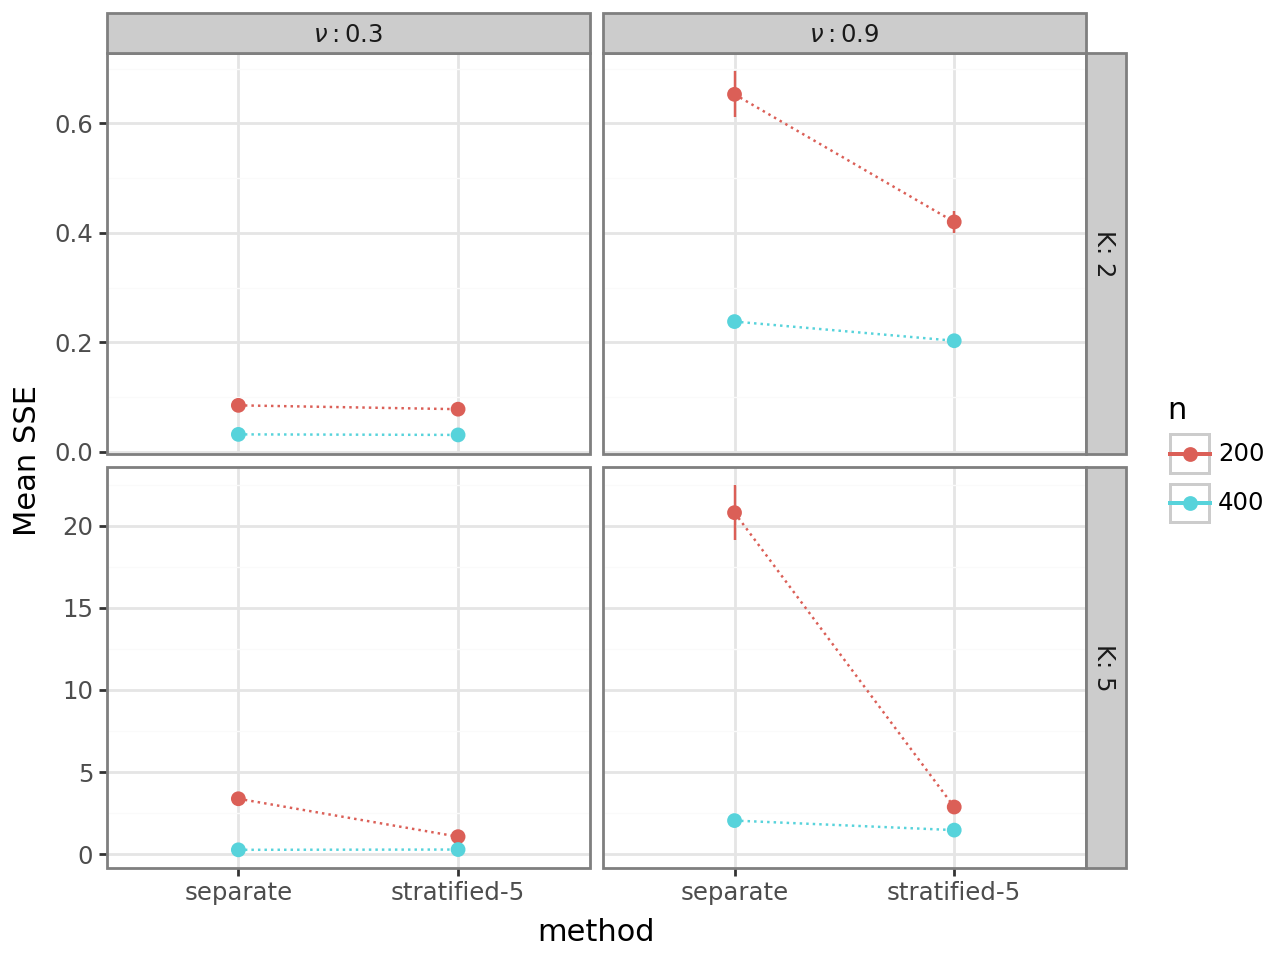

In [47]:
unev = 1
y = "SSE"
res = pd.read_csv(f"first30_{unev}.csv")

agg_plot = np.round(res.iloc[:,:].groupby(by=["k","p","n","uneven","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)
agg_plot.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg_plot = agg_plot.reset_index()
agg_plot["n"] = pd.Categorical(agg_plot["n"])
agg_plot

lab = labeller(cols={"0.3":r"$\nu: 0.3$","0.9":r"$\nu: 0.9$"},rows={"2":"K: 2","5":"K: 5"})
### OK

plot = ggplot(agg_plot)+aes(x="method",y=y+" - Mean",ymin = y+" - lo",ymax = y+" - high",color="n",group="n")+geom_pointrange()+geom_line(linetype = "dotted")
plot = plot+facet_grid(cols="rho",rows="k",scales="free",labeller=lab)+theme_bw()+labs(y=f"Mean {y}")
ggsave(plot,f"{y}30_{unev}",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\{y}30_{unev}",dpi=200,width=10,height=6)
plot

### Noise effect


In [70]:
p = 30
unev = 0
res1 = pd.read_csv(f"noise30_{unev}.csv")

pd.set_option("display.max_rows", None, "display.max_columns", None)
agg = np.round(res1.groupby(by=["k","p","n","uneven","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:[np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]]),3)
agg.columns = ["SSPE - Mean","SSPE - IC","SSE - Mean","SSE - IC"]


In [71]:
agg_plot = np.round(res1.iloc[:,:].groupby(by=["k","p","n","uneven","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)

In [72]:
agg_plot

SSPE                        \
                                       <lambda_0> <lambda_1> <lambda_2>   
k p  n   uneven rho sigma method                                          
2 30 200 0      0.3 0.5   separate         18.047     17.300     18.793   
                          stratified-5     17.555     16.836     18.274   
                    1.0   separate         70.877     67.911     73.843   
                          stratified-5     68.839     65.982     71.696   
                    1.5   separate        158.065    151.549    164.581   
                          stratified-5    153.230    146.865    159.595   
                    2.0   separate        283.277    271.787    294.767   
                          stratified-5    274.679    263.638    285.720   
5 30 200 0      0.3 0.5   separate         57.937     54.197     61.677   
                          stratified-5     26.861     25.672     28.049   
                    1.0   separate        217.682    204.705    230.658   
                          stratified-5     96.279     92.229    100.330   
                    1.5   separate        489.269    463.256    515.282   
                          stratified-5    205.532    197.311    213.753   
                    2.0   separate        921.540    864.789    978.291   
                          stratified-5    359.049    344.754    373.344   

                                              SSE                        
                                       <lambda_0> <lambda_1> <lambda_2>  
k p  n   uneven rho sigma method                                         
2 30 200 0      0.3 0.5   separate          0.244      0.233      0.255  
                          stratified-5      0.220      0.210      0.230  
                    1.0   separate          1.051      1.001      1.102  
                          stratified-5      0.939      0.894      0.984  
                    1.5   separate          2.414      2.317      2.510  
                          stratified-5      2.156      2.075      2.237  
                    2.0   separate          4.137      3.962      4.313  
                          stratified-5      3.696      3.542      3.850  
5 30 200 0      0.3 0.5   separate          5.296      4.955      5.637  
                          stratified-5      1.591      1.541      1.641  
                    1.0   separate         19.548     18.601     20.495  
                          stratified-5      4.908      4.751      5.066  
                    1.5   separate         44.408     42.196     46.620  
                          stratified-5     10.148      9.839     10.458  
                    2.0   separate         85.129     80.588     89.670  
                          stratified-5     17.885     17.319     18.451

In [73]:
agg_plot.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg_plot = agg_plot.reset_index()
agg_plot.head()

,k,p,n,uneven,rho,sigma,method,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,2,30,200,0,0.3,0.5,separate,18.047,17.300,18.793,0.244,0.233,0.255
1,2,30,200,0,0.3,0.5,stratified-5,17.555,16.836,18.274,0.220,0.210,0.230
2,2,30,200,0,0.3,1.0,separate,70.877,67.911,73.843,1.051,1.001,1.102
3,2,30,200,0,0.3,1.0,stratified-5,68.839,65.982,71.696,0.939,0.894,0.984
4,2,30,200,0,0.3,1.5,separate,158.065,151.549,164.581,2.414,2.317,2.510


In [74]:
for col in agg_plot.columns[:6]:
    agg_plot[col] = pd.Categorical(agg_plot[col])

agg_plot = agg_plot.rename(columns={"rho":"nu","k":"K"})

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: noiseSSE30_0
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\noiseSSE30_0


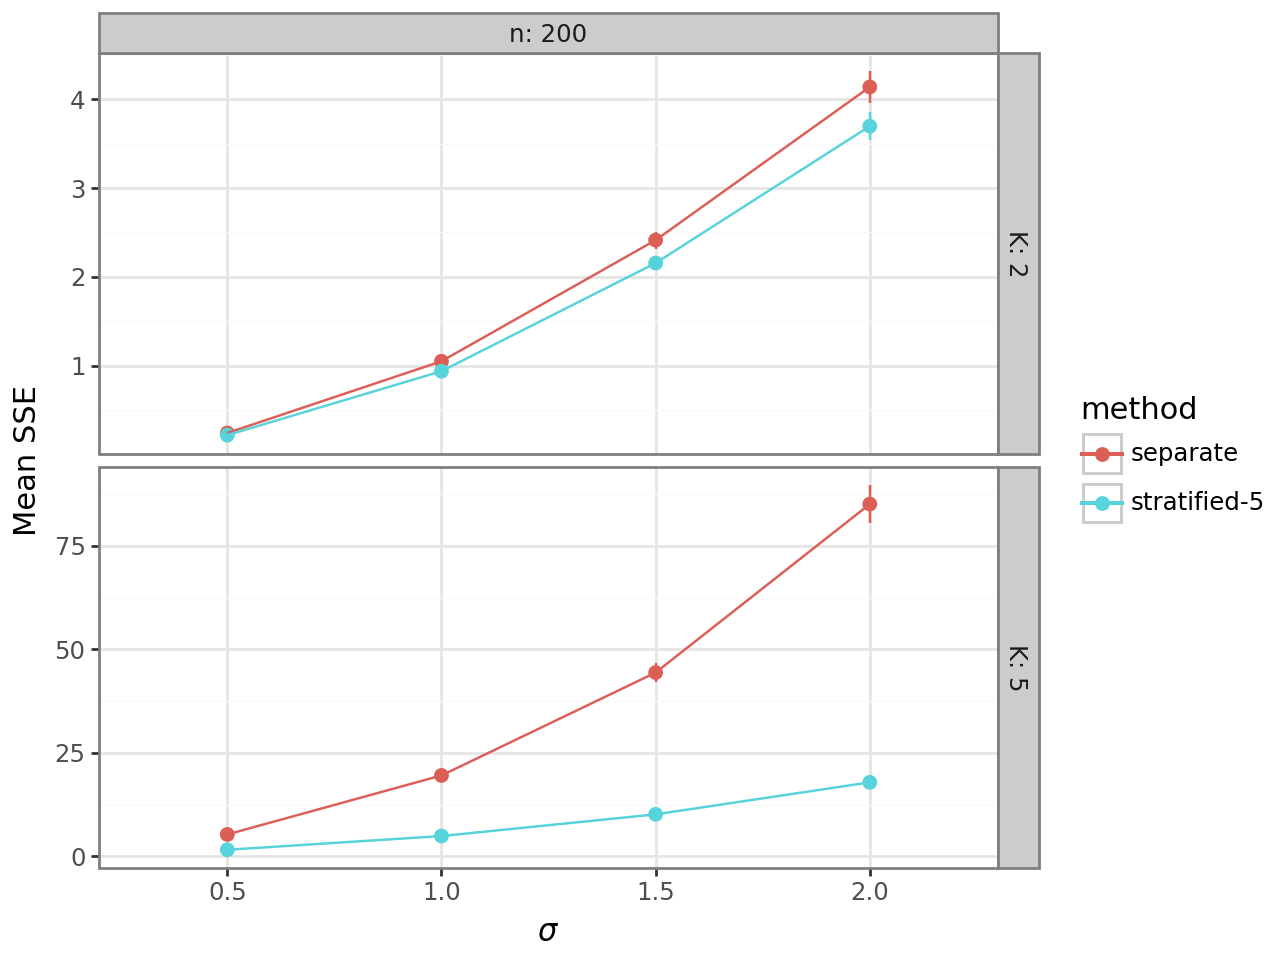

In [76]:
y = "SSE"

plot = ggplot(agg_plot[(agg_plot.p == p)&(agg_plot.uneven == unev)])+aes(x="sigma",y=y+" - Mean",ymin = y+" - lo",ymax = y+" - high",color="method",group="method")+geom_pointrange(position = position_dodge(width = 0))
plot = plot+facet_grid(cols="n",rows="K",scales="free",labeller="label_both")+geom_line()
plot = plot+labs(x=r"$\sigma$",y="Mean "+y)+theme_bw()
ggsave(plot,f"noise{y}{p}_{unev}",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\noise{y}{p}_{unev}",dpi=200,width=10,height=6)
plot

### Correlation effect

In [85]:
p = 30
unev = 0
rescor = pd.read_csv(f"cor30_{unev}.csv")
agg_plot = np.round(rescor.drop(["sigma"],axis=1).iloc[:,:].groupby(by=["k","p","n","uneven","rho","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)
agg_plot.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg_plot = agg_plot.reset_index()
agg_plot.head()
for col in agg_plot.columns[:6]:
    agg_plot[col] = pd.Categorical(agg_plot[col])

agg_plot = agg_plot.rename(columns={"rho":"nu","k":"K"})

In [86]:
agg_plot = agg_plot[agg_plot.nu != 0.6]

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: SSECor30_0
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\SSECor30_0


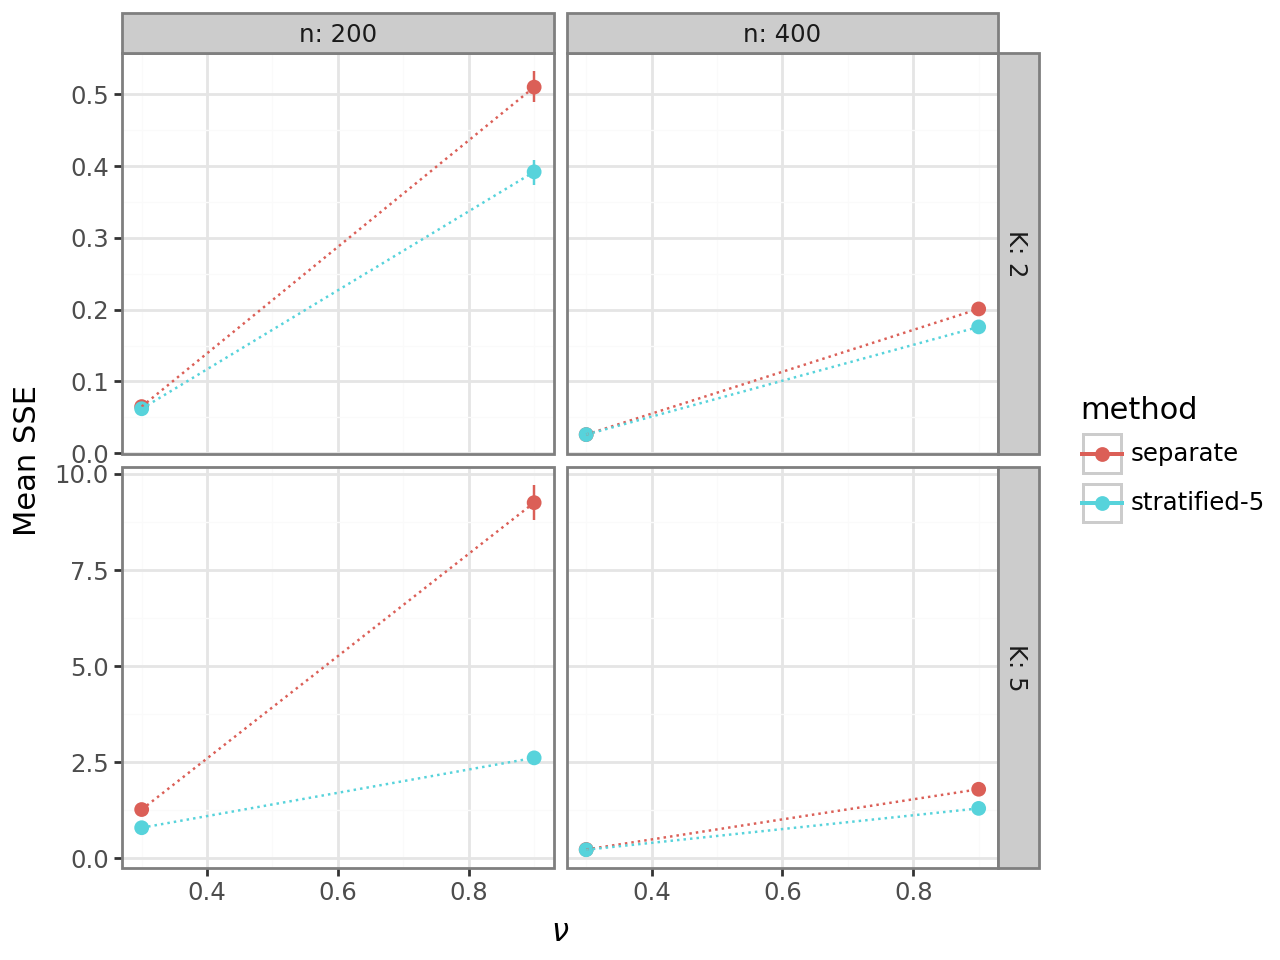

In [87]:

y = "SSE"
agg_plot["nu"] = pd.to_numeric(agg_plot["nu"])
plot = ggplot(agg_plot[(agg_plot.p == p)&(agg_plot.uneven == unev)])+aes(x="nu",y=y+" - Mean",ymin = y+" - lo",ymax = y+" - high",color="method")+geom_pointrange()+facet_grid(cols = "n",rows="K",scales="free_y",labeller="label_both")
plot = plot+labs(x=r"$\nu$",y="Mean "+y)+theme_bw()+geom_line(linetype = "dotted")
ggsave(plot,f"{y}Cor{p}_{unev}",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\{y}Cor{p}_{unev}",dpi=200,width=10,height=6)
plot

### Sample size effect

In [88]:
p = 30
unev = 0
res = pd.read_csv(f"sample30_{unev}.csv")

res["ratio"] = (res["n"]/res["k"])/res["p"]
res = res.drop("n",axis=1)
res.head()

,k,p,uneven,rho,sigma,method,SSPE,SSE,ratio
0,2,30,0,0.3,0.25,separate,86.038321,4.153818,1.00
1,2,30,0,0.3,0.25,stratified-5,12.777745,0.505160,1.00
2,5,30,0,0.3,0.25,separate,28.989838,2.523798,0.40
3,5,30,0,0.3,0.25,stratified-5,58.492166,4.665719,0.40
4,2,30,0,0.3,0.25,separate,10.496295,0.437370,1.25


In [90]:
# p = 30, rho = 0.3
agg = np.round(res.groupby(by=["k","p","ratio","uneven","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)

agg.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg = agg.reset_index()
for col in agg.columns[:6]:
    if col != "ratio":
        agg[col] = pd.Categorical(agg[col])



agg = agg.rename(columns={"rho":"nu","k":"K"})
agg

,K,p,ratio,uneven,nu,sigma,method,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,2,30,1.000000,0,0.3,0.25,separate,287.908,191.212,384.604,12.576,8.992,16.160
1,2,30,1.000000,0,0.3,0.25,stratified-5,16.149,15.030,17.269,0.618,0.576,0.661
2,2,30,1.250000,0,0.3,0.25,separate,17.807,16.109,19.504,0.708,0.626,0.790
3,2,30,1.250000,0,0.3,0.25,stratified-5,10.911,10.211,11.611,0.363,0.341,0.385
4,2,30,1.500000,0,0.3,0.25,separate,10.043,9.474,10.612,0.325,0.304,0.346
5,2,30,1.500000,0,0.3,0.25,stratified-5,8.033,7.648,8.418,0.233,0.221,0.245
6,2,30,1.750000,0,0.3,0.25,separate,7.472,7.075,7.870,0.205,0.193,0.216
7,2,30,1.750000,0,0.3,0.25,stratified-5,6.588,6.269,6.908,0.167,0.158,0.175
8,2,30,2.000000,0,0.3,0.25,separate,6.405,6.117,6.693,0.158,0.149,0.166
9,2,30,2.000000,0,0.3,0.25,stratified-5,6.048,5.783,6.314,0.138,0.132,0.145


C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: SSEsamp30_0
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\SSEsamp30_0


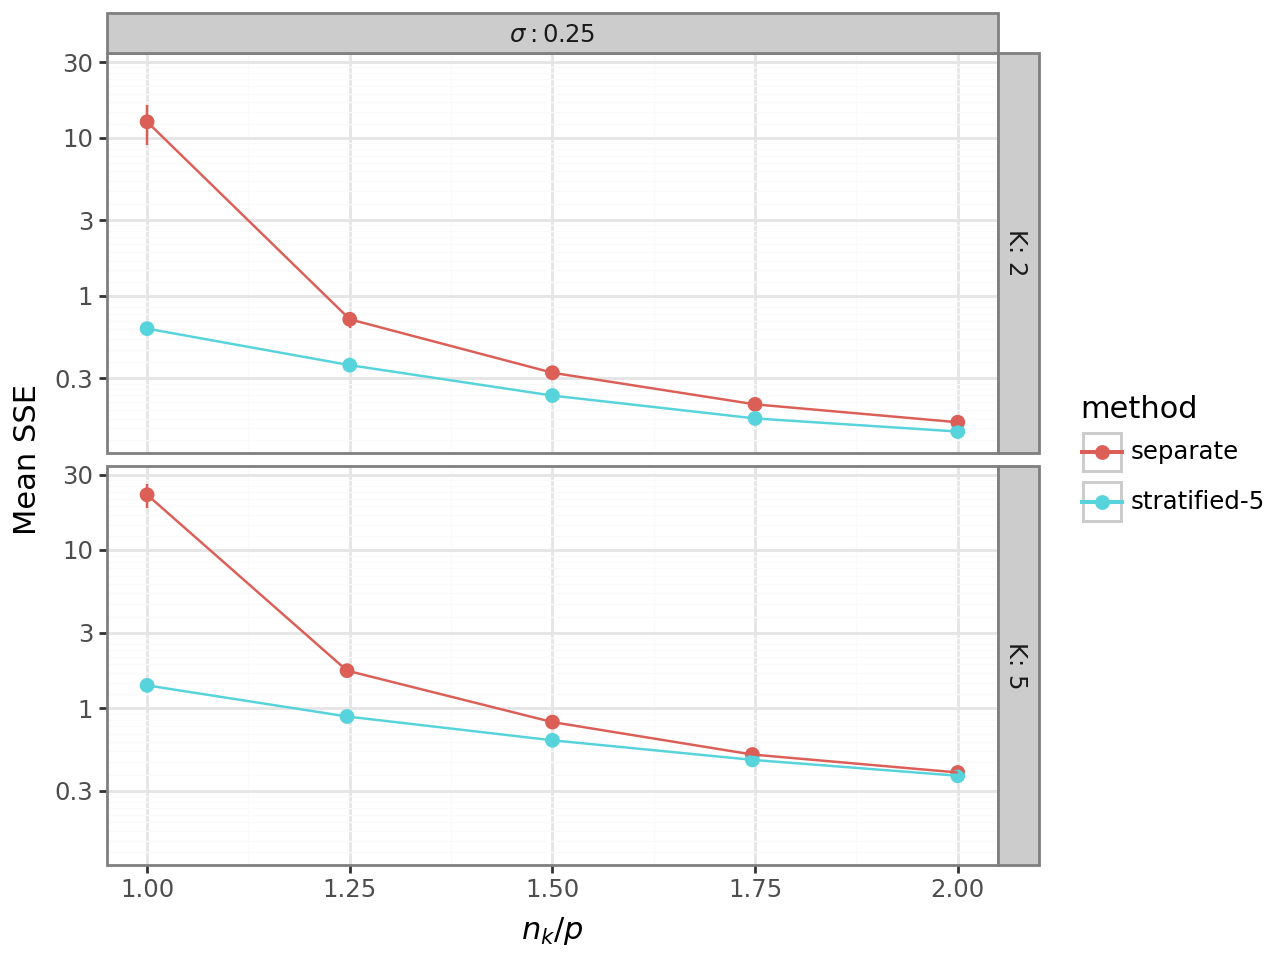

In [93]:

y = "SSE"
plot = ggplot(agg[(agg.uneven == unev)&(agg.ratio >= 1)&(agg.ratio <= 2)])+aes(x="ratio",y=y+" - Mean",ymin = y+" - lo",ymax = y+" - high",color="method",group="method")+geom_pointrange()+geom_point()+geom_line()+theme_bw()+scale_y_log10() 
lab = labeller(cols={"0.25":r"$\sigma: 0.25$"},rows={"2":"K: 2","5":"K: 5"})
plot = plot+labs(x=r"$n_k/p$",y="Mean SSE")+facet_grid(cols = "sigma",rows="K",labeller=lab)
ggsave(plot,f"{y}samp{p}_{unev}",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\{y}samp{p}_{unev}",dpi=200,width=10,height=6)
plot

### Variance effect

In [169]:
res = pd.read_csv("simulation_study1_sigma.csv")
agg = np.round(res.groupby(by=["k","p","n","uneven","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)
agg

SSPE                            \
                                         <lambda_0>   <lambda_1>   <lambda_2>   
k p  n   uneven rho sigma method                                                
2 50 10  0      0.3 0.25  common             28.819       25.391       32.247   
                          separate           24.224       21.023       27.424   
                          stratified-5       28.831       25.356       32.306   
     25  0      0.3 0.25  common             40.420       35.942       44.897   
                          separate           22.635       19.708       25.562   
                          stratified-5       39.951       35.722       44.180   
     50  0      0.3 0.25  common        2369274.045 -2159644.291  6898192.381   
                          separate           16.512       15.168       17.856   
                          stratified-5      209.113      162.413      255.813   
     75  0      0.3 0.25  common             46.187       39.994       52.381   
                          separate           18.570       16.402       20.738   
                          stratified-5       27.852       25.195       30.509   
     100 0      0.3 0.25  common             31.203       28.277       34.129   
                          separate          360.439      153.785      567.094   
                          stratified-5       15.664       13.877       17.450   
     125 0      0.3 0.25  common             25.035       22.758       27.311   
                          separate           17.341       15.162       19.521   
                          stratified-5       10.611        9.692       11.531   
     150 0      0.3 0.25  common             23.269       21.765       24.772   
                          separate            9.151        8.147       10.155   
                          stratified-5        7.925        7.011        8.839   
     175 0      0.3 0.25  common             20.522       19.078       21.965   
                          separate            7.606        6.813        8.399   
                          stratified-5        6.980        6.307        7.653   
     200 0      0.3 0.25  common             21.272       19.441       23.104   
                          separate            6.282        5.790        6.773   
                          stratified-5        5.993        5.542        6.443   
     225 0      0.3 0.25  common             18.285       16.303       20.266   
                          separate            5.518        4.914        6.123   
                          stratified-5        5.290        4.745        5.836   
     250 0      0.3 0.25  common             20.813       19.324       22.302   
                          separate            5.115        4.701        5.530   
                          stratified-5        5.035        4.663        5.407   
     275 0      0.3 0.25  common             20.814       19.070       22.557   
                          separate            5.047        4.534        5.559   
                          stratified-5        4.996        4.502        5.490   
     300 0      0.3 0.25  common             18.358       16.867       19.849   
                          separate            4.882        4.490        5.275   
                          stratified-5        4.817        4.427        5.207   
5 50 10  0      0.3 0.25  common             58.779       51.712       65.846   
                          separate           41.112       37.840       44.384   
                          stratified-5       58.741       51.585       65.897   
     25  0      0.3 0.25  common             95.311       84.701      105.921   
                          separate           39.205       36.320       42.089   
                          stratified-5       94.446       83.954      104.938   
     50  0      0.3 0.25  common         222872.186   -87585.383   533329.755   
                          separate           35.345       32.083       38.607 

In [170]:
agg.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg = agg.reset_index()
agg.head()

,k,p,n,uneven,rho,sigma,method,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,2,50,10,0,0.3,0.25,common,28.819,25.391,32.247,1.064,1.037,1.092
1,2,50,10,0,0.3,0.25,separate,24.224,21.023,27.424,0.906,0.873,0.939
2,2,50,10,0,0.3,0.25,stratified-5,28.831,25.356,32.306,1.065,1.037,1.092
3,2,50,25,0,0.3,0.25,common,40.420,35.942,44.897,1.440,1.335,1.545
4,2,50,25,0,0.3,0.25,separate,22.635,19.708,25.562,0.802,0.775,0.828


In [171]:
agg = agg.rename(columns={"rho":"nu"})

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


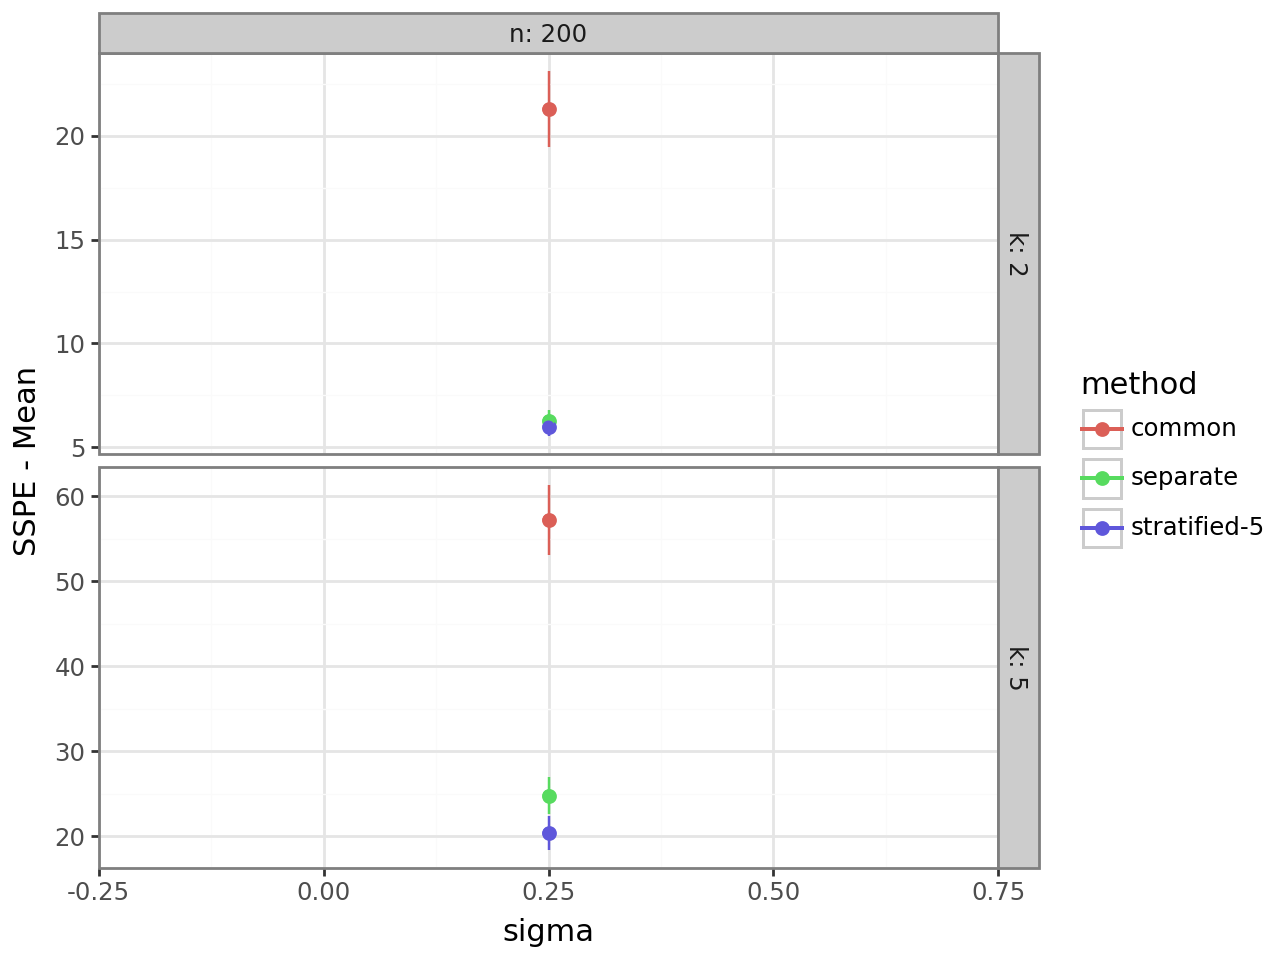

In [173]:
plot = ggplot(agg[agg.n == 200])+aes(x="sigma",y="SSPE - Mean",ymin = "SSPE - lo",ymax = "SSPE - high",color="method")+geom_pointrange()+geom_point()+geom_line()+facet_grid(rows="k",cols="n",labeller="label_both",scales="free_y")+theme_bw()
name = "SSPEVar" 
# ggsave(plot,name,dpi=200,width=10,height=6)
# ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\"+name,dpi=200,width=10,height=6)
plot

### Simulation study - II

In [5]:
def get_coefs(x,dim):
    return np.sin(x/2)*np.ones(dim)

#### Number of bins

In [79]:
np.random.seed(1234)

n_test = 50
n_rep = 100

dim = 25
n = 500
rhos = [0.3]
sigmas = [1/4]

k = [10,25,50,100,250,400,500]

#weights = {10:[20.1,20.8],25:[19.425,20],50:[10.8,11.8],100:[8.3,9],250:[28.1,29.25],400:[69.5,70.5],500:[95.7,96.7]}
weights = {10:[20.5],25:[19.75],50:[11.4],100:[8.475],250:[28.7],400:[70.25],500:[96.2]}
# Create graphs
sep = [nx.path_graph(k_val) for k_val in k]
strat = [nx.path_graph(k_val) for k_val in k]

for i in range(len(k)):
    strat_models.set_edge_weight(sep[i],0)
    strat_models.set_edge_weight(strat[i],1)
    
graphs = {"stratified":strat}


results2 = pd.DataFrame(columns=["k","rho","sigma","method","SSPE","SSE"])

for i in range(n_rep):
    for rho in rhos:
        for sigma in sigmas:
            for k_index in range(len(k)):
                # Generate all of the data
                x = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
                X = generate_data(n,dim,rho)

                label = np.zeros(shape=n)
                coefs = get_coefs(x,dim)


                Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
                Y = np.reshape(Y,(n,1))

                for j in range(k[k_index]):
                    rows = (x>=j*10/k[k_index])&(x<(j+1)*10/k[k_index])
                    rows = rows.T.flatten()
                    label[rows] = j

                # Generate test data
                x_test = np.reshape(np.random.uniform(low=0,high=10,size=n_test),newshape=(n_test,1))
                X_test = generate_data(n_test,dim,rho)

                coefs_test = get_coefs(x_test,dim)
                Y_test = np.diag(X_test@coefs_test.T)+sigma*np.random.randn(n_test)
                
                Y_test = np.reshape(Y_test,(n_test,1))
                

                
                # Fit models and evaluate their performance
                base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))

                for method in graphs:
                    if method ==  "stratified":
                        for weight in weights[k[k_index]]:
                            dat_train = dict(X=X, Y=Y, Z=label)
                            G = graphs[method][k_index].copy()
                            # set weight
                            strat_models.set_edge_weight(G,weight)
                            mod = strat_models.StratifiedModel(base, graph=G)
                            mod.fit(dat_train)    

                            SSPE = 0
                            SSE = 0
                            # Compute sum of squares prediction error (out of sample)
                            for j in range(k[k_index]):
                                rows = (x_test>=j*10/k[k_index])&(x_test<(j+1)*10/k[k_index])
                                rows = rows.T.flatten()

                                SSPE += np.sum(((X_test[rows]@mod.G.nodes[j]["theta"]).flatten()-
                                                        Y_test[rows].flatten())**2)
                                SSE += np.sum((np.tile(mod.G.nodes[j]["theta"].flatten(),(np.sum(rows),1))-coefs_test[rows])**2)

                            results2.loc[len(results2)] = [k[k_index],rho,sigma,method+f"-{weight}",SSPE,SSE] 
                    else:
                        dat_train = dict(X=X, Y=Y, Z=label)
                        G = graphs[method][k_index].copy()
                        
                        mod = strat_models.StratifiedModel(base, graph=G)
                        mod.fit(dat_train)    

                        SSPE = 0
                        SSE = 0
                        # Compute sum of squares prediction error (out of sample)
                        for j in range(k[k_index]):
                            rows = (x_test>=j*10/k[k_index])&(x_test<(j+1)*10/k[k_index])
                            rows = rows.T.flatten()

                            SSPE += np.sum(((X_test[rows]@mod.G.nodes[j]["theta"]).flatten()-
                                                    Y_test[rows].flatten())**2)
                            SSE += np.sum((np.tile(mod.G.nodes[j]["theta"].flatten(),(np.sum(rows),1))-coefs_test[rows])**2)

                        results2.loc[len(results2)] = [k[k_index],rho,sigma,method,SSPE,SSE] 

                # Oracle SSPE and SSE
                SSPE = np.sum((np.diag(X_test@coefs_test.T)-Y_test.flatten())**2)
                results2.loc[len(results2)] = [k[k_index],rho,sigma,"Oracle",SSPE,0] 
                print(results2[-4:])
                print(np.round(len(results2)/(n_rep*len(rhos)*len(sigmas)*len(k)*3)*100,1)/2,"%")

results2.to_csv("binsStratified.csv",index=False)

    k  rho  sigma           method        SSPE        SSE
0  10  0.3   0.25  stratified-20.5  105.249516  57.110431
1  10  0.3   0.25           Oracle    4.466383   0.000000
0.05 %
    k  rho  sigma            method        SSPE        SSE
0  10  0.3   0.25   stratified-20.5  105.249516  57.110431
1  10  0.3   0.25            Oracle    4.466383   0.000000
2  25  0.3   0.25  stratified-19.75   20.677417  28.524388
3  25  0.3   0.25            Oracle    2.756745   0.000000
0.1 %
    k  rho  sigma            method       SSPE        SSE
2  25  0.3   0.25  stratified-19.75  20.677417  28.524388
3  25  0.3   0.25            Oracle   2.756745   0.000000
4  50  0.3   0.25   stratified-11.4  58.617063  23.682667
5  50  0.3   0.25            Oracle   3.587993   0.000000
0.15 %
     k  rho  sigma            method       SSPE        SSE
4   50  0.3   0.25   stratified-11.4  58.617063  23.682667
5   50  0.3   0.25            Oracle   3.587993   0.000000
6  100  0.3   0.25  stratified-8.475   8.320

In [80]:
res2 = pd.read_csv("binsStratified.csv")
agg = np.round(res2.groupby(by=["k","rho","sigma","method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)]),3)

In [81]:
agg.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg = agg.reset_index()
for col in agg.columns[1:3]:
    agg[col] = pd.Categorical(agg[col])



agg = agg.rename(columns={"rho":"nu"})
agg

,k,nu,sigma,method,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,10,0.3,0.25,Oracle,3.154,3.037,3.271,0.000,0.000,0.000
1,10,0.3,0.25,stratified-20.5,96.773,85.866,107.681,64.758,60.460,69.055
2,25,0.3,0.25,Oracle,3.130,3.022,3.238,0.000,0.000,0.000
3,25,0.3,0.25,stratified-19.75,42.812,36.039,49.585,26.143,23.833,28.452
4,50,0.3,0.25,Oracle,3.071,2.958,3.184,0.000,0.000,0.000
5,50,0.3,0.25,stratified-11.4,22.517,18.873,26.161,14.855,13.393,16.316
6,100,0.3,0.25,Oracle,3.160,3.032,3.287,0.000,0.000,0.000
7,100,0.3,0.25,stratified-8.475,18.267,14.924,21.610,12.154,10.828,13.480
8,250,0.3,0.25,Oracle,3.095,2.983,3.206,0.000,0.000,0.000
9,250,0.3,0.25,stratified-28.7,15.495,13.374,17.617,10.000,9.118,10.881


In [86]:
agg["method"] = agg.apply(lambda x:"oracle" if x["method"].lower() == "oracle" else "stratified",axis=1)

In [87]:
agg

,k,nu,sigma,method,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,10,0.3,0.25,oracle,3.154,3.037,3.271,0.000,0.000,0.000
1,10,0.3,0.25,stratified,96.773,85.866,107.681,64.758,60.460,69.055
2,25,0.3,0.25,oracle,3.130,3.022,3.238,0.000,0.000,0.000
3,25,0.3,0.25,stratified,42.812,36.039,49.585,26.143,23.833,28.452
4,50,0.3,0.25,oracle,3.071,2.958,3.184,0.000,0.000,0.000
5,50,0.3,0.25,stratified,22.517,18.873,26.161,14.855,13.393,16.316
6,100,0.3,0.25,oracle,3.160,3.032,3.287,0.000,0.000,0.000
7,100,0.3,0.25,stratified,18.267,14.924,21.610,12.154,10.828,13.480
8,250,0.3,0.25,oracle,3.095,2.983,3.206,0.000,0.000,0.000
9,250,0.3,0.25,stratified,15.495,13.374,17.617,10.000,9.118,10.881


C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: SSPEbin
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\SSPEbin


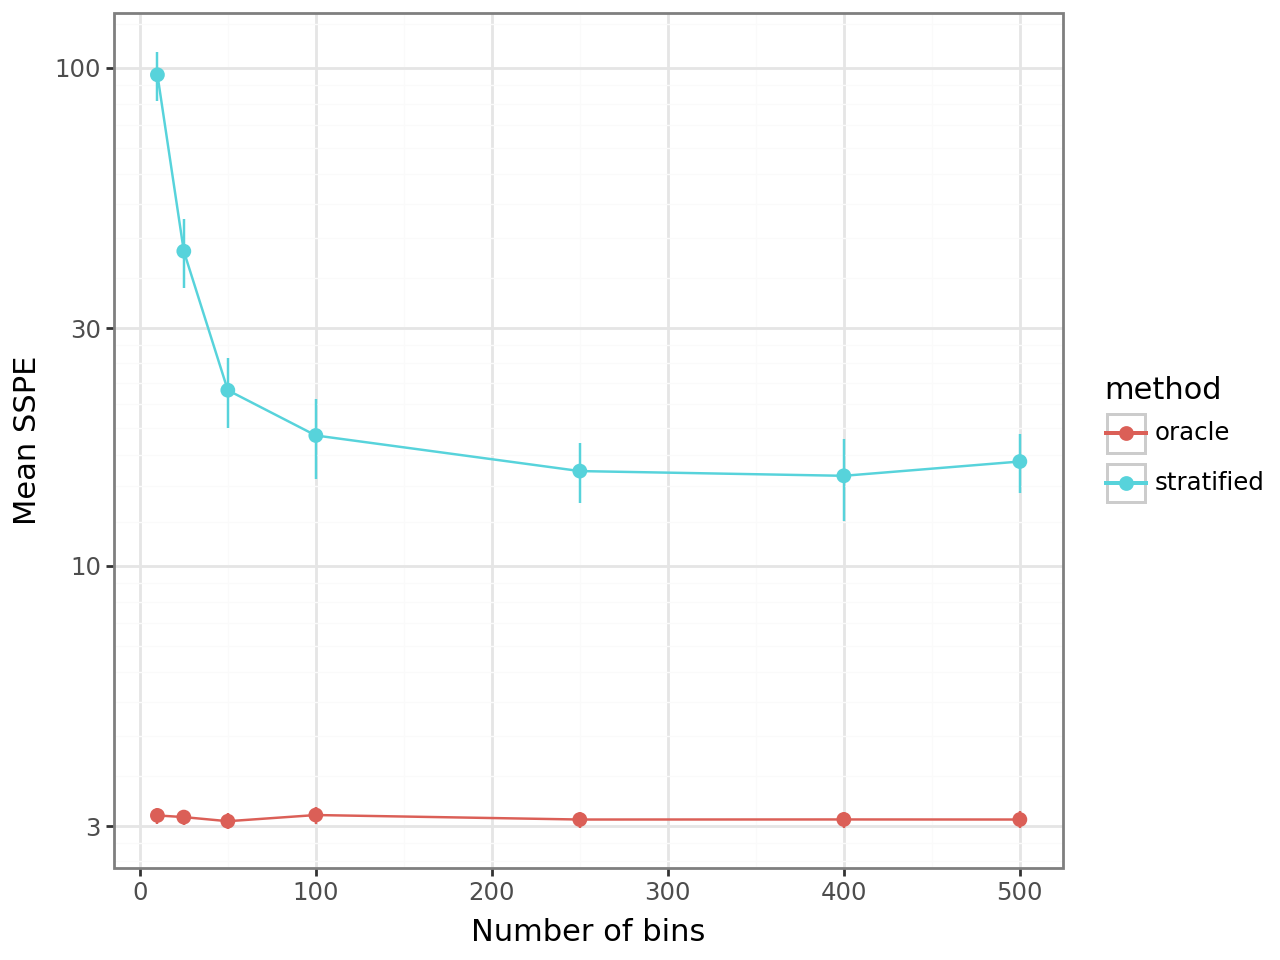

In [88]:
y = "SSPE"
plot = ggplot(agg)+aes(x="k",y=y+" - Mean",ymin = y+" - lo",ymax = y+" - high",color="method",group="method")+geom_pointrange()+geom_point()+geom_line()
plot = plot+labs(x="Number of bins",y="Mean "+y)+theme_bw()+scale_y_log10()
ggsave(plot,y+"bin",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\{y}bin",dpi=200,width=10,height=6)
plot

### Continuous binning

#### Figure out hyperparameters

In [257]:
#np.random.seed(1234)
dim = 25
n = 500
rho = 0.3
sigma = 1/4
K = 400


In [267]:
import statsmodels.api as sm

param_number = 0
perfs = pd.DataFrame(columns = ["Method","param","SSE"])

def GaussianKernel(d,h):
    return np.exp(-(d)**2/(2*h**2))
def ExpKernel(d,h):
    return np.exp(-d/(2*h))
def BoxCarKernel(d,h):
    if d >= h:
        return 0
    else:
        return 1
def BiSquareKernel(d,h):
    if d >= h:
        return 0
    else:
        return (1-(d/h)**2)**2

kernels = [GaussianKernel,ExpKernel,BoxCarKernel,BiSquareKernel]
kernel_names = ["Gaussian","Exponential","Box-Car","BiSquare"]
kernel_boundaries = [[0.375, 0.45], [0.125,0.19], [0.741, 0.772], [0.96,1.06]]
kernel_boundaries = [[0.3,0.375], [0.07,0.125], [0.772,0.85], [1.004, 1.027]]
kernel_boundaries = [[0.365,0.38], [0.124,0.126], [0.82, 0.85], [1.027,1.06]]
kernel_boundaries = [[0.37,0.47], [0.115,0.125], [0.74,0.84], [1.04,1.14]]
kernel_boundaries = [[0.414, 0.437], [0.120,0.135], [0.83,1], [1.14,1.6]]
kernel_bandwidths = [[0.414],[0.135],[0.962],[1.19]]


for i in range(150):
    # Generate all of the data
    h = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
    h.sort(axis=0)
    X = generate_data(n,dim,rho)
    coefs = get_coefs(h,dim)

    Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
    Y = np.reshape(Y,(n,1))


    # GWLS results
    for kernel_index in range(len(kernel_names)):
        for GWLS_b in kernel_bandwidths[kernel_index]:
            GWLS_params = []
            for current_h in h:
                weights = []
                for i in range(len(h)):
                    weights.append(kernels[kernel_index](np.abs((current_h-h[i]))[0],GWLS_b))

                res = sm.WLS(Y,X,weights).fit()
                GWLS_params.append(res.params[param_number])
            score = np.sum((np.array(GWLS_params)-np.sin(h/2).flatten())**2)
            perfs.loc[len(perfs)] = [kernel_names[kernel_index],GWLS_b,score]

    # Variable binning results
    label = np.zeros(len(Y))
    stops = np.linspace(0,13,K)[1:]
    for weight in np.linspace(70.25-3,70.25+3,3):
        for i in range(len(Y)):
            label[i] = (stops>h[i]).argmax()
        dat_train = dict(X=X, Y=Y, Z=label)
        bin_graph = nx.path_graph(K) 
        strat_models.set_edge_weight(bin_graph,weight)

        base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
        mod = strat_models.StratifiedModel(base, graph=bin_graph)
        mod.fit(dat_train)
        binned_param = []
        for i in range(len(h)):
            binned_param.append(mod.G.nodes[label[i]]["theta"][param_number][0])

        score = np.sum((np.array(binned_param)-np.sin(h/2).flatten())**2)
        perfs.loc[len(perfs)] = ["Standard",weight,score]

In [327]:
import winsound
winsound.Beep(440, 500)
winsound.PlaySound("SystemExclamation", winsound.SND_ALIAS)

In [269]:
averaged = perfs.groupby(by=["Method","param"]).mean().reset_index()
new = []
for ker in kernel_names:
    min_index = np.argmin(averaged[averaged["Method"] == ker]["SSE"])
    if min_index == 0:
        print(ker,averaged[averaged["Method"] == ker].iat[min_index,1],"]")
        new.append(averaged[averaged["Method"] == ker].iat[min_index,1])
    elif min_index == 9:
        print(ker,"[",averaged[averaged["Method"] == ker].iat[min_index,1])
        new.append(averaged[averaged["Method"] == ker].iat[min_index,1])
    else: 
        lo=  np.round(averaged[averaged["Method"] == ker].iat[min_index-1,1],3)
        hi=  np.round(averaged[averaged["Method"] == ker].iat[min_index+1,1],3)
        sclo = np.round(averaged[averaged["Method"] == ker].iat[min_index-1,2],3)
        schi = np.round(averaged[averaged["Method"] == ker].iat[min_index+1,2],3)
        sc = averaged[averaged["Method"] == ker].iat[min_index,2]
        print(ker,f"[{lo},{hi}],[{sclo},{schi}],{sc}")
        new.append([lo,hi])

Gaussian 0.414 ]
Exponential 0.135 ]
Box-Car 0.962 ]
BiSquare 1.19 ]


In [221]:
new

[0.414, 0.135, [0.943, 0.981], [1.14, 1.242]]

In [272]:
perfs.groupby(by=["Method","param"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)])

SSE                      
                   <lambda_0> <lambda_1> <lambda_2>
Method      param                                  
BiSquare    1.190   13.993628     12.975     15.012
Box-Car     0.962   21.876914     20.456     23.298
Exponential 0.135   10.635554      9.880     11.391
Gaussian    0.414   12.214537     11.318     13.111
Standard    67.250   2.576899      2.373      2.781
            70.250   2.589002      2.383      2.795
            73.250   2.600298      2.393      2.808

#### Use them in one simulation

In [358]:
n=500
# Generate all of the data
h = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
h.sort(axis=0)
X = generate_data(n,dim,rho)
coefs = get_coefs(h,dim)

Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
Y = np.reshape(Y,(n,1))


# GWLS
results = pd.DataFrame(columns=["Method","h","paramEstimation"])
kernel_names = ["Gaussian","Exponential","Box-Car","BiSquare"]
kernel_bandwidths = [0.414,0.135,0.962,1.19]
for kernel_index in range(len(kernel_names)):
        GWLS_b = kernel_bandwidths[kernel_index]
        GWLS_params = []
        for current_h in h:
            weights = []
            for i in range(len(h)):
                weights.append(kernels[kernel_index](np.abs((current_h-h[i]))[0],GWLS_b))

            res = sm.WLS(Y,X,weights).fit()
            results.loc[len(results)] = [kernel_names[kernel_index],current_h[0],res.params[param_number]]


# Variable binning
K = 400
label = np.zeros(len(Y))
stops = np.linspace(0,13,K)[1:]
for i in range(len(Y)):
    label[i] = (stops>h[i]).argmax()
dat_train = dict(X=X, Y=Y, Z=label)
W = 70.25
bin_graph = nx.path_graph(K) 
strat_models.set_edge_weight(bin_graph,W)

base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
mod = strat_models.StratifiedModel(base, graph=bin_graph)
mod.fit(dat_train)
for i in range(len(h)):
    results.loc[len(results)] = ["Stratified",h[i][0],mod.G.nodes[label[i]]["theta"][param_number][0]]


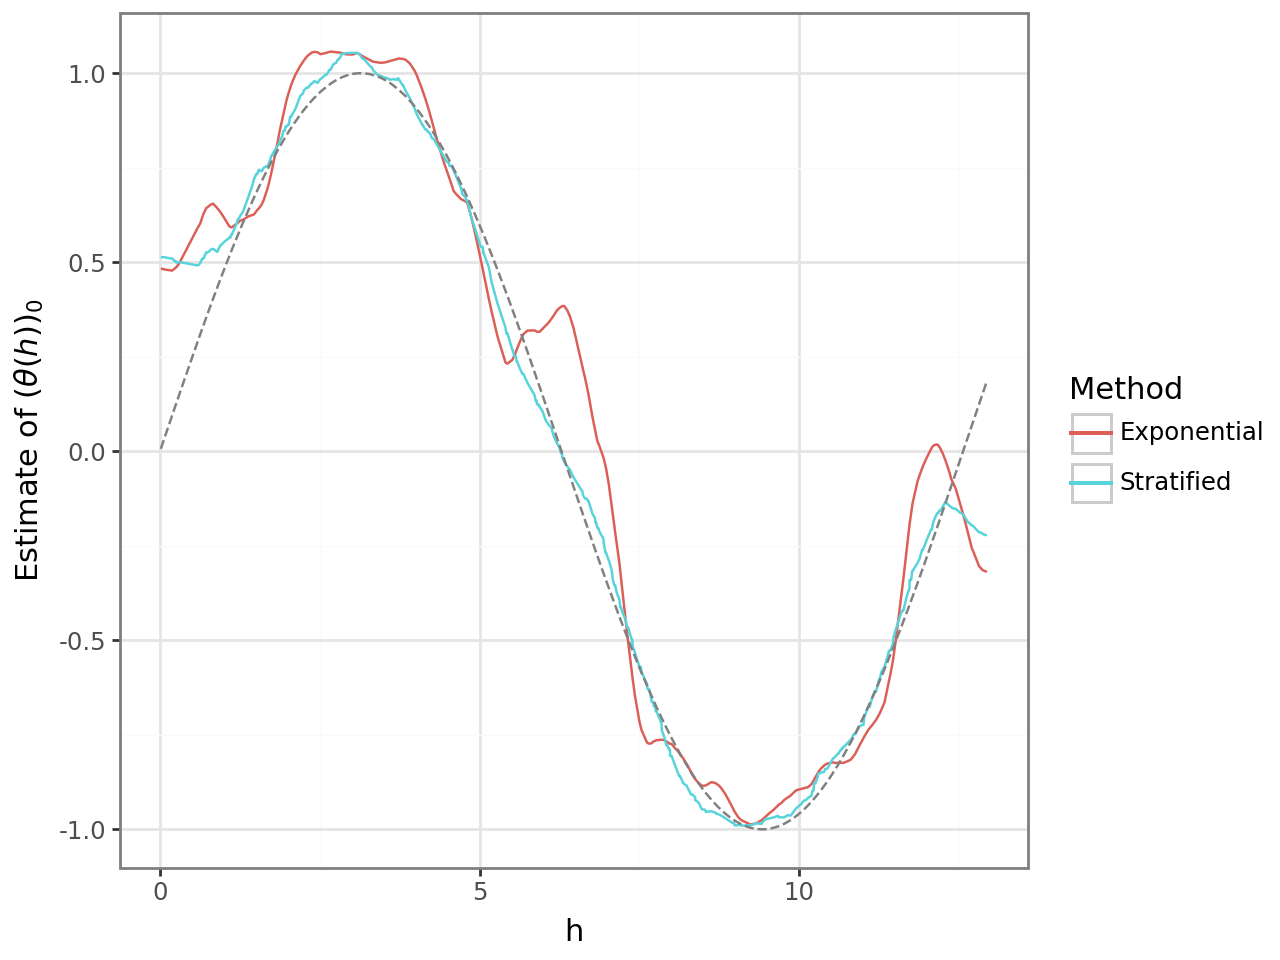

In [359]:
results["true"] = np.sin(results["h"]/2)
plot = ggplot(results[(results["Method"] == "Stratified")|(results["Method"] == "Exponential")])+aes(x="h",y="paramEstimation",color="Method")+geom_line()+geom_line(aes(x="h",y="true"),color="gray",linetype = "dashed")+theme_bw()
plot = plot+labs(y=r"Estimate of $\left(\theta(h)\right)_0$")
plot

In [278]:
results["SE"]=results.apply(lambda x:(x["paramEstimation"]-x["true"])**2,axis = 1)
results[["Method","SE"]].groupby("Method").sum()

,SE
Method,
BiSquare,17.221043
Box-Car,25.118026
Exponential,14.839564
Gaussian,15.423669
LRSM,2.466458


In [122]:
np.sum(results[results["Method"] == "Variable binning"].apply(lambda x:(x["paramEstimation"]-x["true"])**2,axis=1))

2.7929518248452583

In [123]:
np.sum(results[results["Method"] == "GWLS"].apply(lambda x:(x["paramEstimation"]-x["true"])**2,axis=1))

11.114756909760866

In [360]:
ggsave(plot,"sinhEstimate",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\sinhEstimate",dpi=200,width=10,height=6)

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: sinhEstimate
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\sinhEstimate


### Pointwise Bias and variance

In [325]:
results = pd.DataFrame(columns=["Method","h","paramEstimation"])

In [326]:
n=500
absc = np.linspace(0,13,50)

for i in range(500):
    # Generate all of the data
    h = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
    h.sort(axis=0)
    X = generate_data(n,dim,rho)
    coefs = get_coefs(h,dim)

    Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
    Y = np.reshape(Y,(n,1))
    # GWLS
    kernel_names = ["Gaussian","Exponential","Box-Car","BiSquare"]
    kernel_bandwidths = [0.414,0.135,0.962,1.19]
    for kernel_index in range(len(kernel_names)):
            GWLS_b = kernel_bandwidths[kernel_index]
            GWLS_params = []
            for current_h in absc:
                weights = []
                for i in range(len(h)):
                    weights.append(kernels[kernel_index](np.abs((current_h-h[i]))[0],GWLS_b))

                res = sm.WLS(Y,X,weights).fit()
                results.loc[len(results)] = [kernel_names[kernel_index],current_h,res.params[param_number]]


    # Variable binning
    K = 400
    label_train = np.zeros(len(Y))
    label_predict = np.zeros(len(absc))

    stops = np.linspace(0,13,K)[1:]
    for i in range(len(Y)):
        label_train[i] = (stops>h[i]).argmax()
    for i in range(len(absc)):
        label_predict[i] = (stops>absc[i]).argmax()

    dat_train = dict(X=X, Y=Y, Z=label_train)
    W = 70.25
    bin_graph = nx.path_graph(K) 
    strat_models.set_edge_weight(bin_graph,W)

    base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
    mod = strat_models.StratifiedModel(base, graph=bin_graph)
    mod.fit(dat_train)
    for i in range(len(absc)):
        results.loc[len(results)] = ["LRSM",absc[i],mod.G.nodes[label_predict[i]]["theta"][param_number][0]]


In [299]:
label

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       133., 137., 141., 145., 149., 153., 157., 161., 165., 169., 173.,
       177., 181., 185., 189., 193., 197., 201., 205., 209., 213., 217.,
       221., 225., 229., 233., 237., 241., 245., 249., 253., 257., 261.,
       266., 270., 274., 278., 282., 286., 290., 294., 298., 302., 306.,
       310., 314., 318., 322., 326., 330., 334., 338., 342., 346., 350.,
       354., 358., 362., 366., 370., 374., 378., 382., 386., 390., 394.,
         0.])

In [8]:
results = pd.read_csv("predictionsLRSMGWR").iloc[:,1:]


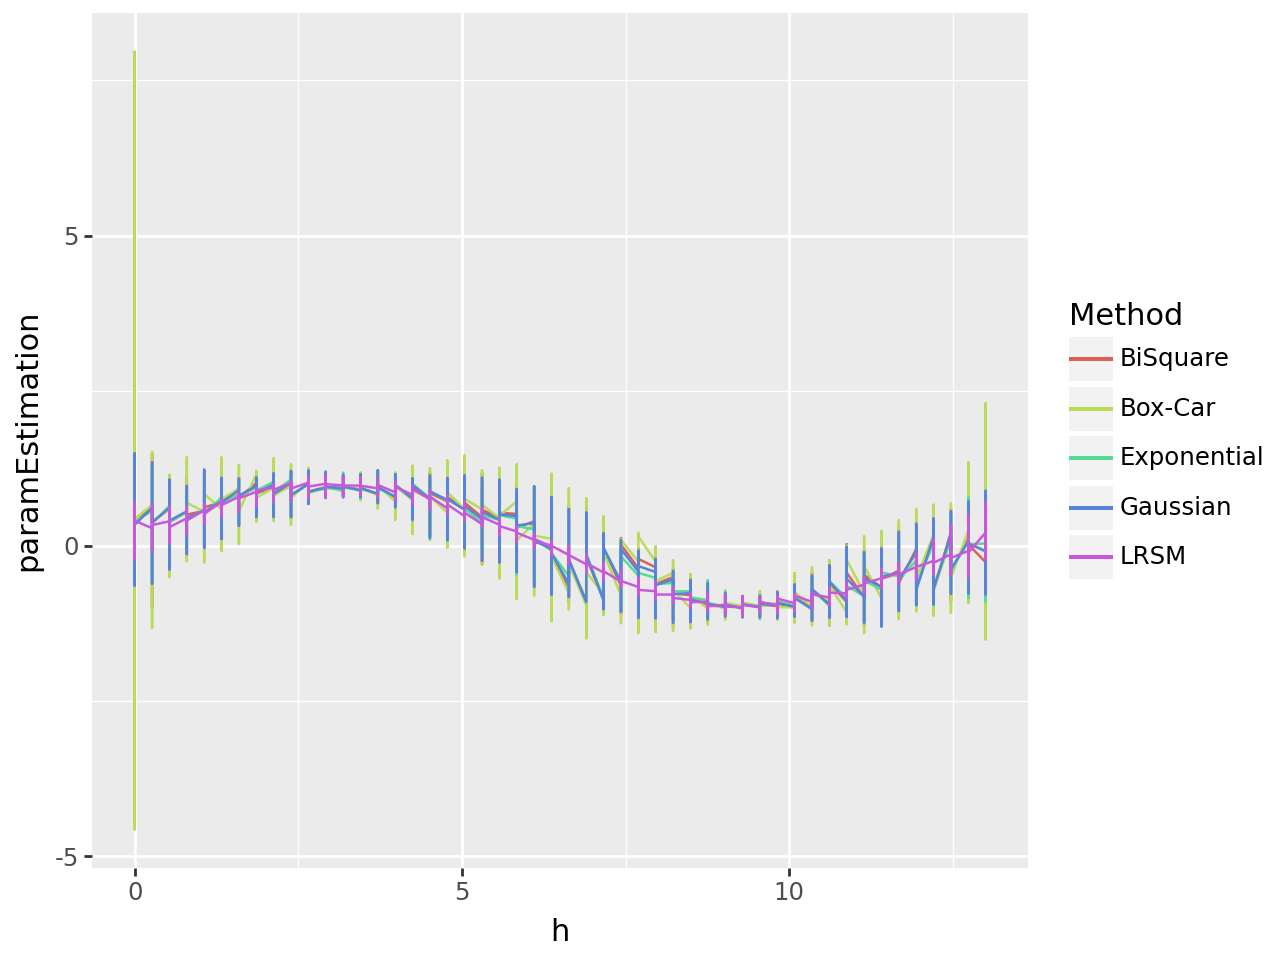

In [9]:
ggplot(results)+aes(x="h",y="paramEstimation",color="Method")+geom_line()

In [10]:
df_res = results.groupby(by=["h","Method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.var(x)])
df_res.columns = ["Pred - Mean","Pred - lo","Pred - high","Variance"]
df_res = df_res.reset_index()
df_res["true"] = np.sin(df_res["h"]/2)
df_res

,h,Method,Pred - Mean,Pred - lo,Pred - high,Variance,true
0,0.0,BiSquare,0.233720,0.206,0.261,0.098747,0.00000
1,0.0,Box-Car,0.243243,0.195,0.292,0.307844,0.00000
2,0.0,Exponential,0.240670,0.216,0.265,0.079110,0.00000
3,0.0,Gaussian,0.228749,0.203,0.254,0.083315,0.00000
4,0.0,LRSM,0.211790,0.198,0.226,0.026537,0.00000
...,...,...,...,...,...,...,...
245,13.0,BiSquare,-0.034218,-0.060,-0.009,0.085817,0.21512
246,13.0,Box-Car,-0.039106,-0.073,-0.005,0.147445,0.21512
247,13.0,Exponential,-0.035582,-0.061,-0.011,0.081246,0.21512
248,13.0,Gaussian,-0.027692,-0.052,-0.003,0.078836,0.21512


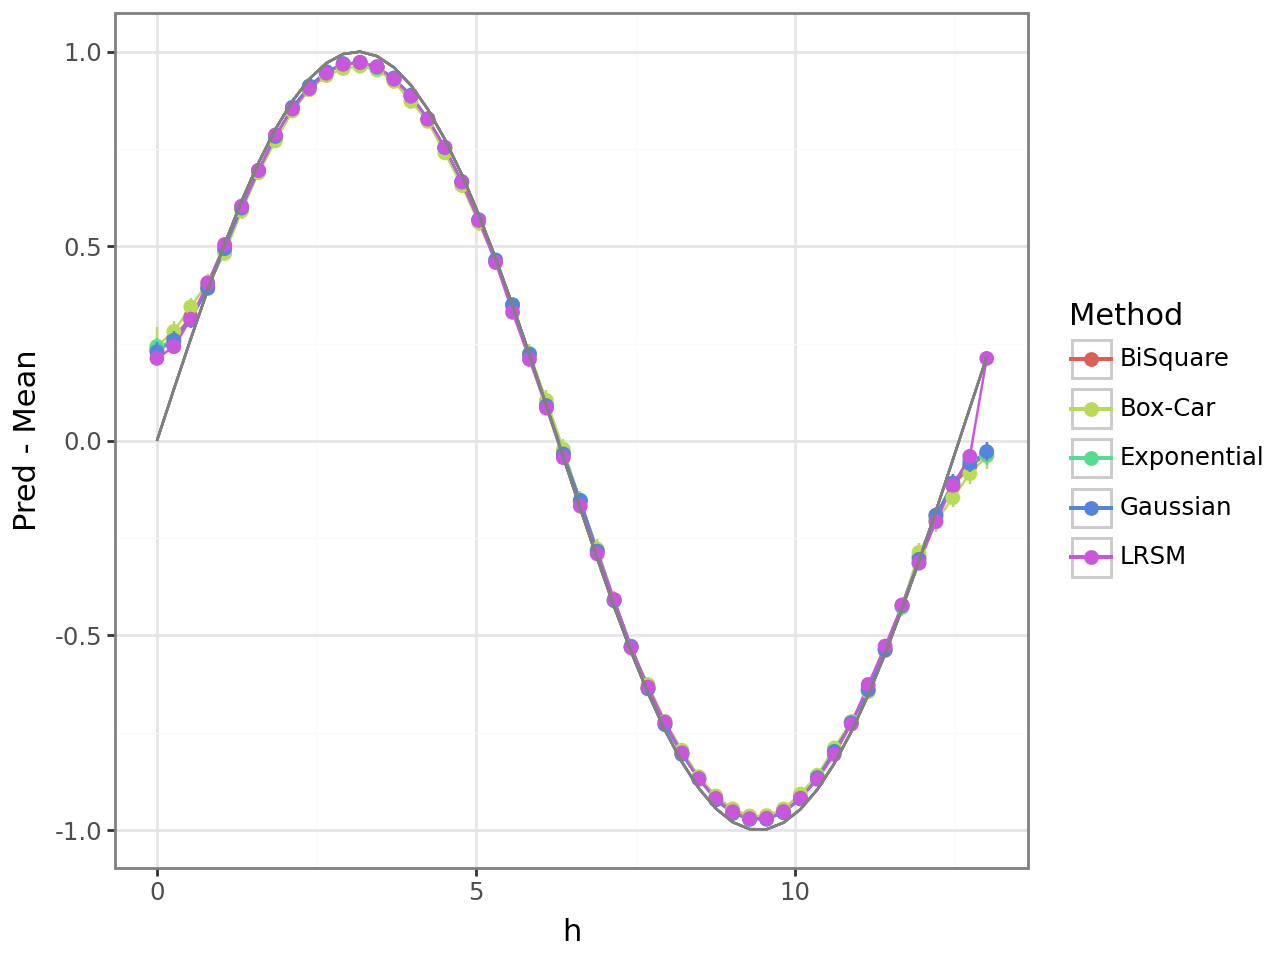

In [11]:
ggplot(df_res)+aes(x="h",y="Pred - Mean",ymin = "Pred - lo",ymax = "Pred - high",color="Method",group="Method")+geom_line()+theme_bw()+geom_pointrange()+geom_line(aes(x="h",y="true"),color="grey")

In [12]:
df_res["Bias"] = df_res["Pred - Mean"]-df_res["true"]
df_res["Bias Lo"] = df_res["Pred - lo"]-df_res["true"]
df_res["Bias Hi"] = df_res["Pred - high"]-df_res["true"]

In [20]:
df_res.Method = df_res.apply(lambda x:x["Method"] if x["Method"] != "LRSM" else "Stratified",axis=1)

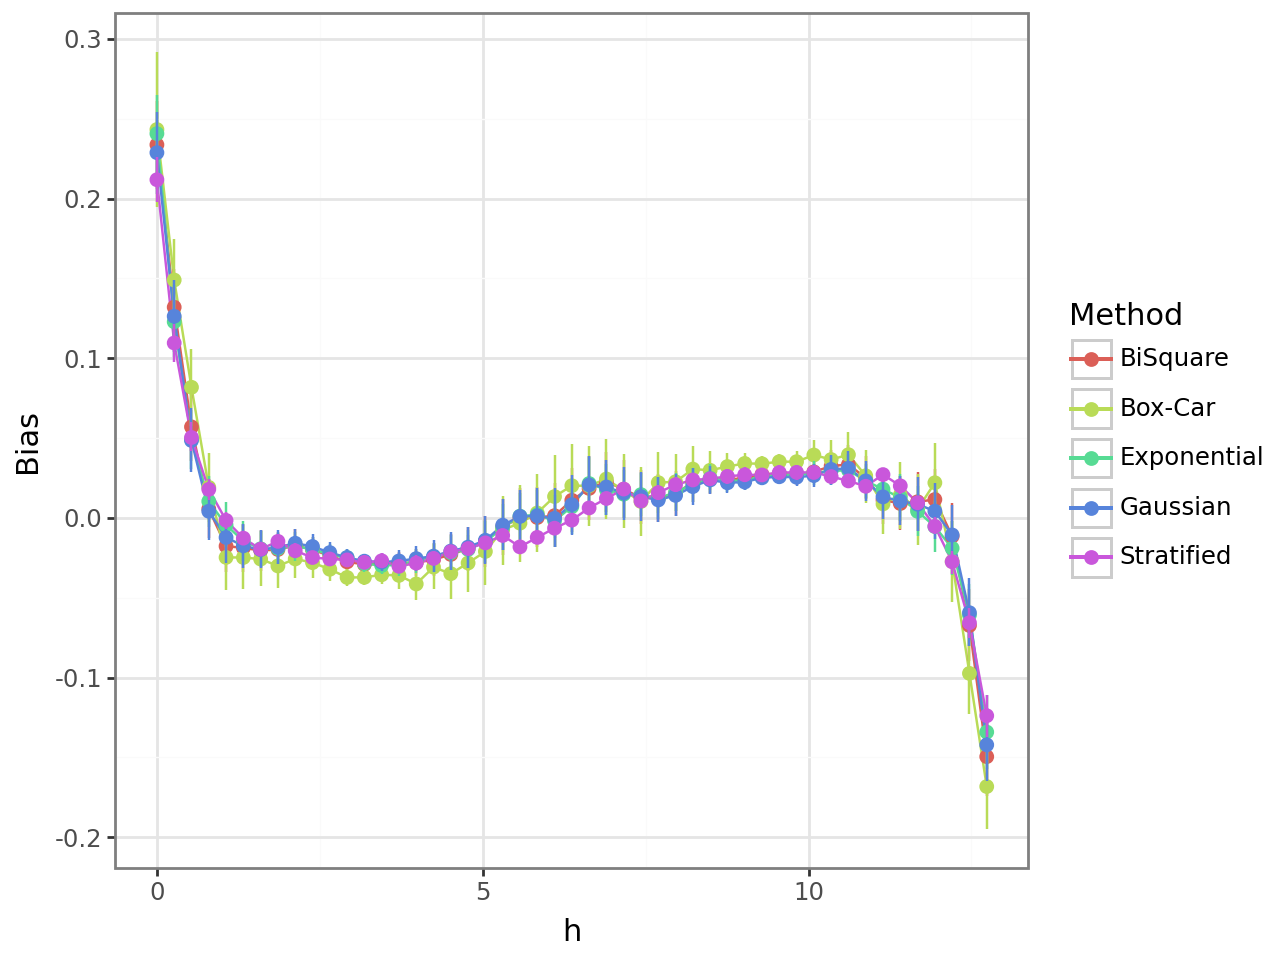

In [22]:
plot = ggplot(df_res[df_res.h<13])+aes(x="h",y="Bias",ymin = "Bias Lo",ymax = "Bias Hi",color="Method",group="Method")+geom_line()+theme_bw()+geom_pointrange()
plot

In [23]:
ggsave(plot,"bias",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\bias",dpi=200,width=10,height=6)

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: bias
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\bias


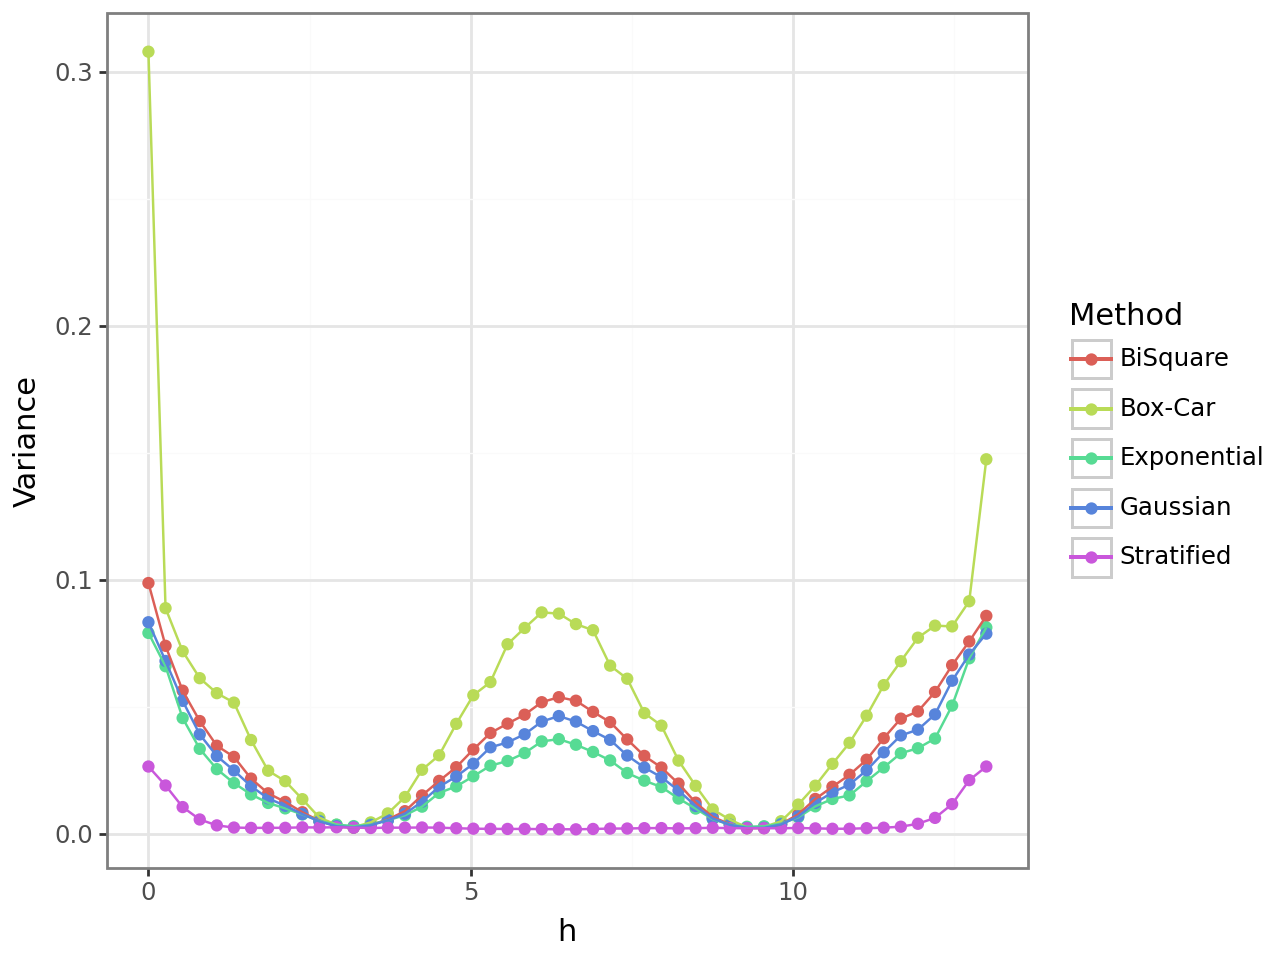

In [24]:
plot = ggplot(df_res)+aes(x="h",y="Variance",color="Method",group="Method")+geom_point()+geom_line()+theme_bw()
plot

In [25]:
ggsave(plot,"variance",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\variance",dpi=200,width=10,height=6)

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: variance
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\variance


## Eigen-tratified Models

### Graph eigenvalues

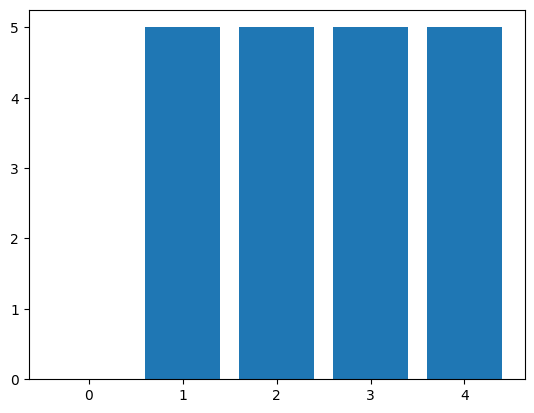

In [66]:
G =  nx.complete_graph(5)

plt.bar(range(5),np.sort(np.linalg.eigvals(nx.laplacian_matrix(G).toarray())))
plt.show()

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part


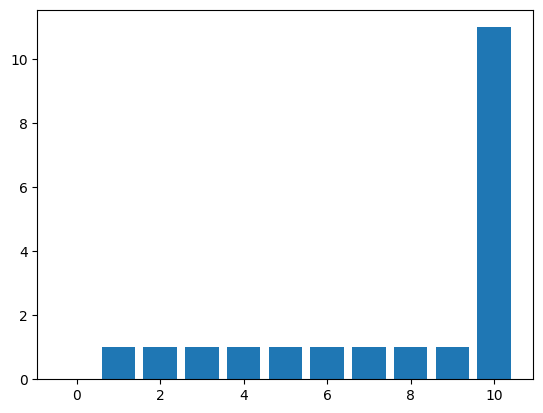

In [82]:
G = nx.star_graph(10)
plt.bar(range(len(G)),np.sort(np.linalg.eigvals(nx.laplacian_matrix(G).toarray())))
plt.show()

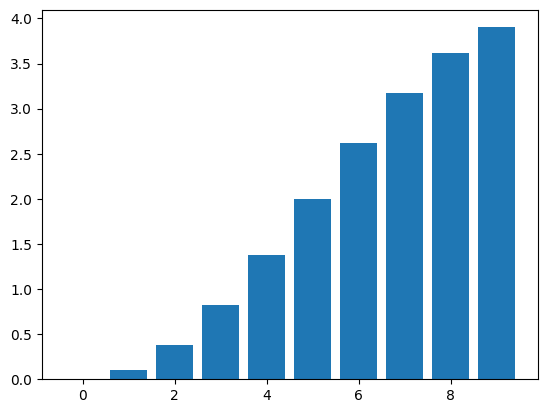

In [197]:
G = nx.path_graph(10)
plt.bar(range(len(G)),np.sort(np.linalg.eigvals(nx.laplacian_matrix(G).toarray())))
plt.show()

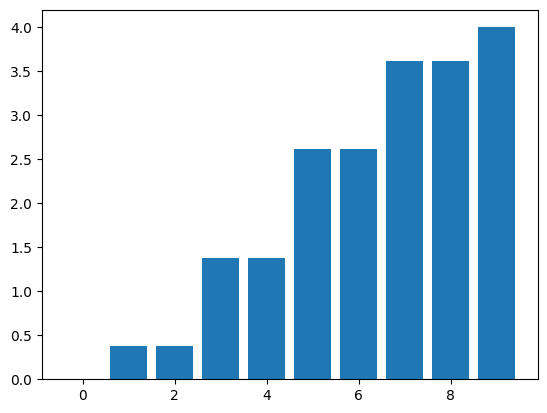

In [198]:
G = nx.cycle_graph(10)
plt.bar(range(len(G)),np.sort(np.linalg.eigvals(nx.laplacian_matrix(G).toarray())))
plt.show()

In [224]:
class lineGraph():
    def __init__(self,K,weight=1) -> None:
        self.G = nx.path_graph(K)
        strat_models.set_edge_weight(self.G,weight)
        self.coefs = None
        self.K = K
        self.name = "lineGraph"
    
    def generateCoefs(self,dim):
        initial_vect = np.random.normal(size=dim)
        initial_vect /= np.linalg.norm(initial_vect)
        self.coefs = np.array([[0]*dim]+[(k+1)*initial_vect for k in range(self.K-1)])

In [225]:
class starGraph():
    def __init__(self,K,weight=1) -> None:
        self.G = nx.star_graph(K-1)
        strat_models.set_edge_weight(self.G,weight)
        self.coefs = None
        self.K = K
        self.name = "starGraph"

    def generateCoefs(self,dim):
        initial_vect = np.random.normal(size=dim)
        initial_vect /= np.linalg.norm(initial_vect)

        # create orhtogonal vector
        second_vector = np.random.normal(size=dim)
        second_vector = second_vector-initial_vect*(np.dot(initial_vect,second_vector))
        second_vector /= np.linalg.norm(second_vector)

        self.coefs = np.array([[0]*dim]+[np.cos(2*np.pi*k/(self.K-1))*initial_vect+np.sin(2*np.pi*k/(self.K-1))*second_vector for k in range(self.K-1)])
            

In [775]:
np.random.seed(1234)
graphConstructors = [lineGraph,starGraph]
K = 10
p = 25
n = 500
n_test = 50
rho = 0.3
sigma = 0.25

res = pd.DataFrame(columns=["Graph","Weight","Sigma","Method","SSPE","SSE"])
for i in range(50):
    for sigma in [0.25,0.75,1.25]:
        for W in [10]:
            for n_eigen in range(1,K+1):
                for graphConstructor in graphConstructors:
                    graph = graphConstructor(K,W)
                    graph.generateCoefs(p)
                    
                    X_train = generate_data(n,p,rho)
                    Y_train = np.zeros(shape=n)
                    labels_train = np.zeros(shape=n)

                    X_test = generate_data(n_test,p,rho)
                    Y_test = np.zeros(shape=n_test)
                    labels_test = np.zeros(shape=n_test)

                    for strata_index in range(K):
                        Y_train[strata_index*(n//K):(strata_index+1)*(n//K)] = X_train[strata_index*(n//K):(strata_index+1)*(n//K),:]@graph.coefs[strata_index].T+sigma*np.random.randn(n//K)
                        labels_train[strata_index*(n//K):(strata_index+1)*(n//K)] = strata_index

                        Y_test[strata_index*(n_test//K):(strata_index+1)*(n_test//K)] = X_test[strata_index*(n_test//K):(strata_index+1)*(n_test//K),:]@graph.coefs[strata_index].T+sigma*np.random.randn(n_test//K)
                        labels_test[strata_index*(n_test//K):(strata_index+1)*(n_test//K)] = strata_index

                    
                    Y_train = Y_train.reshape((n,1))
                    base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
                    mod = strat_models.StratifiedModel(BaseModel=base,graph=graph.G)

                    dat_train = dict(X=X_train,Y=Y_train,Z=labels_train)
                    mod.fit(dat_train,num_eigen=n_eigen)

                    dat_test = dict(X=X_test,Y=Y_test,Z=labels_test)
                    SSPE = np.sum((mod.predict(dat_test).flatten()-dat_test['Y'])**2)

                    SSE = 0
                    for strata_index in range(K):
                        SSE += np.sum((mod.G.nodes[strata_index]["theta"].flatten()-graph.coefs[strata_index])**2)
                    preds = pd.DataFrame({"Graph":[graph.name],"Weight":W,"Sigma":sigma,"Method":[n_eigen],"SSPE":[SSPE],"SSE":SSE})
                    res = pd.concat([res,preds])
    

C:\Users\thoma\AppData\Local\Temp\ipykernel_40612\1529828145.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [777]:

res["Sigma"] = pd.Categorical(res["Sigma"])
agg = res.groupby(by=["Graph","Method","Weight","Sigma"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3)])
agg.columns = ["SSPE - Mean","SSPE - lo","SSPE - high","SSE - Mean","SSE - lo","SSE - high"]
agg = agg.reset_index()

C:\Users\thoma\AppData\Local\Temp\ipykernel_40612\2237011770.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [761]:
agg

,Graph,Method,Weight,Sigma,SSPE - Mean,SSPE - lo,SSPE - high,SSE - Mean,SSE - lo,SSE - high
0,lineGraph,1,5,1.25,538.325140,467.425,609.225,88.464279,87.299,89.629
1,lineGraph,1,10,1.25,544.488253,460.905,628.071,88.363663,87.075,89.652
2,lineGraph,1,20,1.25,480.699866,376.761,584.639,88.114773,86.915,89.315
3,lineGraph,2,5,1.25,87.418226,79.645,95.191,3.439935,3.099,3.781
4,lineGraph,2,10,1.25,91.012911,80.550,101.476,3.026097,2.730,3.322
5,lineGraph,2,20,1.25,89.508000,78.367,100.649,3.090093,2.753,3.428
6,lineGraph,3,5,1.25,104.789800,92.223,117.356,4.667827,4.290,5.046
7,lineGraph,3,10,1.25,105.140944,90.918,119.364,4.561528,4.341,4.782
8,lineGraph,3,20,1.25,97.435893,88.177,106.694,4.481165,4.113,4.849
9,lineGraph,4,5,1.25,96.899127,88.296,105.503,4.516308,4.050,4.983


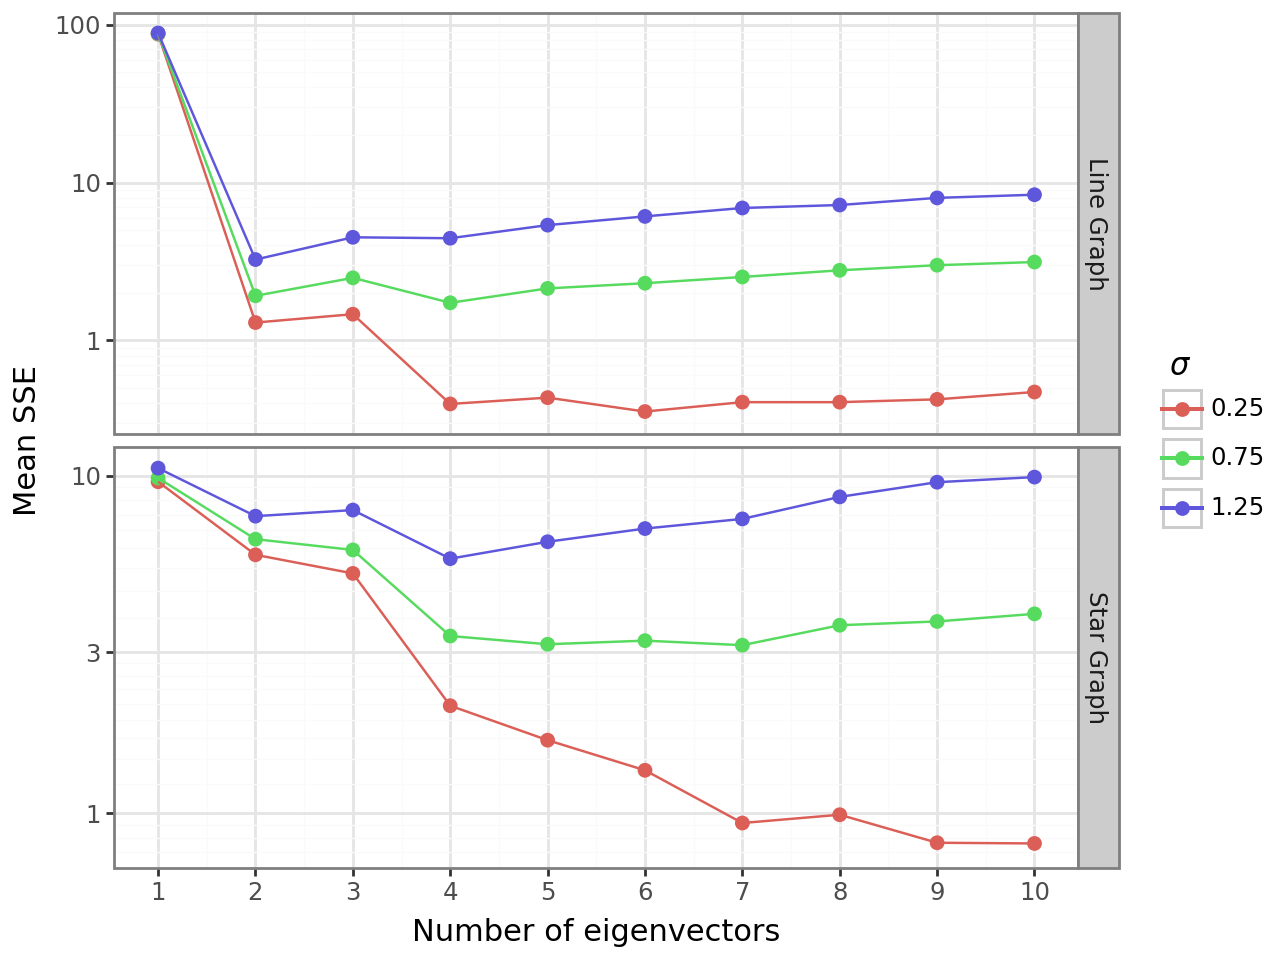

In [783]:
lab = labeller(rows={"lineGraph":"Line Graph","starGraph":"Star Graph"})
y= "SSE"
plot = ggplot(agg)+aes(x="Method",y=f"{y} - Mean",ymin = f"{y} - lo",ymax = f"{y} - high",color = "Sigma",group="Sigma")+geom_pointrange()+geom_line()+facet_grid(rows="Graph", scales = "free_y",labeller=lab)
plot = plot+scale_y_log10()+theme_bw()+scale_x_continuous(breaks=[k+1 for k in range(10)])#+theme(legend_position="none")
plot = plot+labs(x="Number of eigenvectors",y="Mean "+y,color=r" $\sigma$")
plot

In [784]:
ggsave(plot,f"eigenvectorSigma{y}",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\eigenvectorSigma{y}",dpi=200,width=10,height=6)

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: eigenvectorSigmaSSE
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\eigenvectorSigmaSSE


### Eigenvectors visualization

In [468]:
K = 4
G = nx.path_graph(K)
eig_comp = np.linalg.eig(nx.laplacian_matrix(G).toarray())
H = nx.star_graph(K-1)
eig_comp2 = np.linalg.eig(nx.laplacian_matrix(H).toarray())

order = np.argsort(eig_comp[0])
order2 = np.argsort(eig_comp2[0])

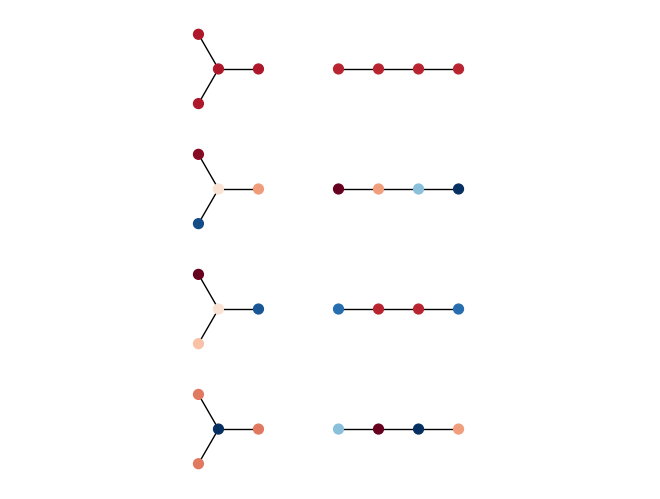

In [592]:
norm = mcolors.Normalize(np.min(eig_comp[1]),np.max(eig_comp[1]))
cmap = cm.RdBu
norm2 = mcolors.Normalize(np.min(eig_comp2[1]),np.max(eig_comp2[1]))
cmap2 = cm.RdBu

v_diff=3
h_diff = 3
size = 50
for i in range(len(G)):
    nx.draw(G,{k:(h_diff+k,-v_diff*i) for k in range(len(G))},node_color=cmap(norm(eig_comp[1].T[order][i])),node_size=size)
    nx.draw(H,{k:(np.cos(2*np.pi*k/(len(H)-1)),-v_diff*i+ np.sin(2*np.pi*k/(len(H)-1))) if k != 0 else (0,-v_diff*i) for k in range(len(H))},node_color=cmap2(norm2(eig_comp2[1].T[order2][i])),
            node_size=size)
plt.axis("equal")
plt.show()

### Eigenvalues visualisation

In [688]:
tplot = pd.DataFrame(columns=["Graph","Eigenvalue Number","Eigenvalue"])
graphConstructors = [lineGraph,starGraph]
for graphConstructor in graphConstructors:
    graph = graphConstructor(10)
    to_add = pd.DataFrame({"Graph":[graph.name]*len(graph.G),"Eigenvalue Number":[k+1 for k in range(len(graph.G))],
                          "Eigenvalue":np.sort(np.linalg.eigvals(nx.laplacian_matrix(graph.G).toarray()))})
    tplot = pd.concat([tplot,to_add])

C:\Users\thoma\AppData\Local\Temp\ipykernel_40612\758143296.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [689]:
tplot["Eigenvalue Number"] = pd.to_numeric(tplot["Eigenvalue Number"])
tplot["col"] = 1
tplot["col"] = pd.Categorical(tplot["col"])

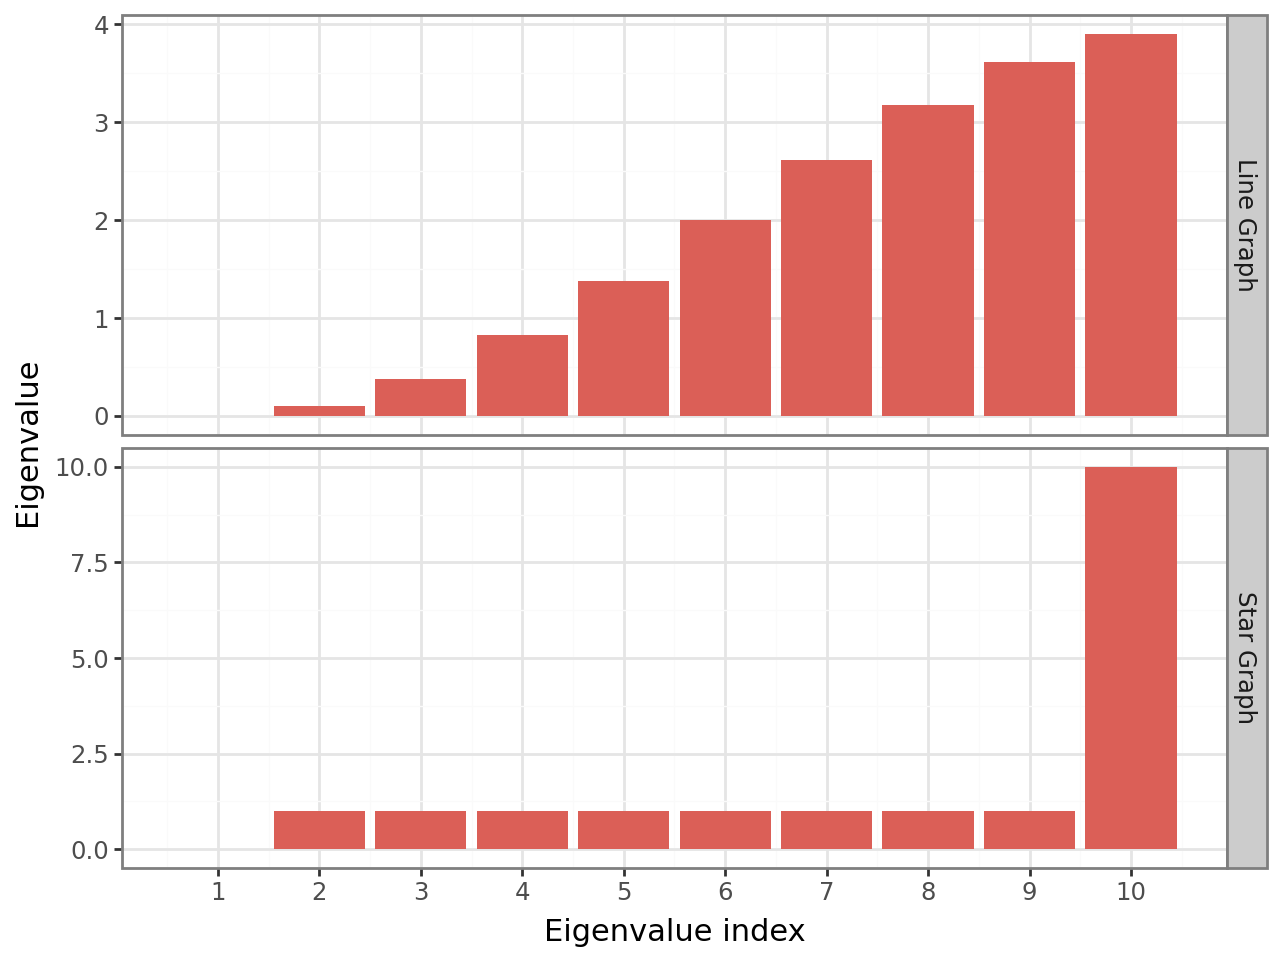

In [691]:
lab = labeller(rows={"lineGraph":"Line Graph","starGraph":"Star Graph"})
plot = ggplot(tplot)+aes(x="Eigenvalue Number",y="Eigenvalue",fill="col")+facet_grid(rows="Graph",labeller=lab,scales="free_y")+labs(x="Eigenvalue index")+theme_bw()
plot = plot+geom_col()+theme(legend_position="none")+scale_x_continuous(breaks=[k+1 for k in range(10)])
plot

In [692]:
ggsave(plot,"eigenvalues",dpi=200,width=10,height=6)
ggsave(plot,f"C:\\Users\\thoma\\OneDrive\\Desktop\\Etudes\\Mémoire Data Science\\Rédaction\\plots\\eigenvalues",dpi=200,width=10,height=6)

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: eigenvalues
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:\Users\thoma\OneDrive\Desktop\Etudes\Mémoire Data Science\Rédaction\plots\eigenvalues
